In [ ]:
import kagglehub
import os
import shutil
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import re
from nltk.corpus import stopwords
import nltk
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('punkt_tab')
from nltk.tokenize import sent_tokenize # Changed 'sent_tokeniz' to 'sent_tokenize'from sklearn.feature_extraction.text import TfidfVectorizer
from wordcloud import WordCloud
from textblob import TextBlob


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


# Load Data

In [ ]:
# Download latest version
path = kagglehub.dataset_download("gowrishankarp/newspaper-text-summarization-cnn-dailymail")

print("Path to dataset files:", path)

100%|██████████| 503M/503M [00:07<00:00, 75.0MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/gowrishankarp/newspaper-text-summarization-cnn-dailymail/versions/2


In [ ]:
pip install rouge-score


  Preparing metadata (setup.py) ... done
  Created wheel for rouge-score: filename=rouge_score-0.1.2-py3-none-any.whl size=24935 sha256=9769ce2b9c600cd93004ec4885380b86d1c16e200f6e205cd6b66a2d38311c71
  Stored in directory: /root/.cache/pip/wheels/1e/19/43/8a442dc83660ca25e163e1bd1f89919284ab0d0c1475475148
Successfully built rouge-score


In [ ]:
# عرض الملفات في المسار الذي تم تحميل البيانات فيه
print("Files in the dataset folder:")
print(os.listdir(path))


Files in the dataset folder:
['cnn_dailymail']


In [ ]:
# عرض الملفات داخل مجلد cnn_dailymail
data_folder = os.path.join(path, "cnn_dailymail")
print("Files inside 'cnn_dailymail':")
print(os.listdir(data_folder))


Files inside 'cnn_dailymail':
['validation.csv', 'train.csv', 'test.csv']


In [ ]:
# تحديد المسار الذي تم تنزيل البيانات إليه
downloaded_path = path  # المسار الذي تم تنزيل البيانات إليه

# تحديد المسار الجديد في /content
new_path = "/content/data"

# التحقق مما إذا كان المسار الجديد موجودًا بالفعل
if os.path.exists(new_path):
    # إذا كان موجودًا، احذفه باستخدام shutil.rmtree
    shutil.rmtree(new_path)

# نقل البيانات إلى /content
shutil.move(downloaded_path, new_path)

print("Data moved to:", new_path)

Data moved to: /content/data


In [ ]:
!ls /content/data

cnn_dailymail


In [ ]:

# تحميل بيانات التدريب
train_data = pd.read_csv('/content/data/cnn_dailymail/train.csv')
test_data = pd.read_csv('/content/data/cnn_dailymail/test.csv')
validation_data = pd.read_csv('/content/data/cnn_dailymail/validation.csv')


# عرض أول بضعة صفوف من البيانات
print(train_data.head())

                                         id  \
0  0001d1afc246a7964130f43ae940af6bc6c57f01   
1  0002095e55fcbd3a2f366d9bf92a95433dc305ef   
2  00027e965c8264c35cc1bc55556db388da82b07f   
3  0002c17436637c4fe1837c935c04de47adb18e9a   
4  0003ad6ef0c37534f80b55b4235108024b407f0b   

                                             article  \
0  By . Associated Press . PUBLISHED: . 14:11 EST...   
1  (CNN) -- Ralph Mata was an internal affairs li...   
2  A drunk driver who killed a young woman in a h...   
3  (CNN) -- With a breezy sweep of his pen Presid...   
4  Fleetwood are the only team still to have a 10...   

                                          highlights  
0  Bishop John Folda, of North Dakota, is taking ...  
1  Criminal complaint: Cop used his role to help ...  
2  Craig Eccleston-Todd, 27, had drunk at least t...  
3  Nina dos Santos says Europe must be ready to a...  
4  Fleetwood top of League One after 2-0 win at S...  


In [ ]:
# عرض أول بضعة صفوف من بيانات التدريب
print(train_data.head())

# الحصول على معلومات عامة عن البيانات
print(train_data.info())

# التحقق من وجود قيم مفقودة
print(train_data.isnull().sum())

                                         id  \
0  0001d1afc246a7964130f43ae940af6bc6c57f01   
1  0002095e55fcbd3a2f366d9bf92a95433dc305ef   
2  00027e965c8264c35cc1bc55556db388da82b07f   
3  0002c17436637c4fe1837c935c04de47adb18e9a   
4  0003ad6ef0c37534f80b55b4235108024b407f0b   

                                             article  \
0  By . Associated Press . PUBLISHED: . 14:11 EST...   
1  (CNN) -- Ralph Mata was an internal affairs li...   
2  A drunk driver who killed a young woman in a h...   
3  (CNN) -- With a breezy sweep of his pen Presid...   
4  Fleetwood are the only team still to have a 10...   

                                          highlights  
0  Bishop John Folda, of North Dakota, is taking ...  
1  Criminal complaint: Cop used his role to help ...  
2  Craig Eccleston-Todd, 27, had drunk at least t...  
3  Nina dos Santos says Europe must be ready to a...  
4  Fleetwood top of League One after 2-0 win at S...  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 

In [ ]:
# حساب طول النصوص والتلخيصات
train_data['article_length'] = train_data['article'].apply(len)
train_data['summary_length'] = train_data['highlights'].apply(len)

test_data['article_length'] = test_data['article'].apply(len)
test_data['summary_length'] = test_data['highlights'].apply(len)

validation_data['article_length'] = validation_data['article'].apply(len)
validation_data['summary_length'] = validation_data['highlights'].apply(len)

# عرض الإحصائيات
print(train_data[['article_length', 'summary_length']].describe())
print(test_data[['article_length', 'summary_length']].describe())
print(validation_data[['article_length', 'summary_length']].describe())

       article_length  summary_length
count   287113.000000   287113.000000
mean      4033.660865      294.770390
std       1954.339234      120.197405
min         48.000000       14.000000
25%       2583.000000      218.000000
50%       3682.000000      280.000000
75%       5117.000000      342.000000
max      15925.000000     7388.000000
       article_length  summary_length
count    11490.000000    11490.000000
mean      3967.077807      311.927241
std       2024.843965      128.027548
min        293.000000       51.000000
25%       2432.000000      223.000000
50%       3563.000000      290.000000
75%       5076.750000      359.000000
max      11991.000000     3410.000000
       article_length  summary_length
count    13368.000000    13368.000000
mean      3923.831912      328.033513
std       1992.463205      146.304859
min        245.000000       52.000000
25%       2404.000000      229.000000
50%       3523.000000      299.000000
75%       5041.000000      386.000000
max      114

<ipython-input-11-1fb8432e3d25>:2: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([train_data['article_length'], train_data['summary_length']], labels=['Article Length', 'Summary Length'])


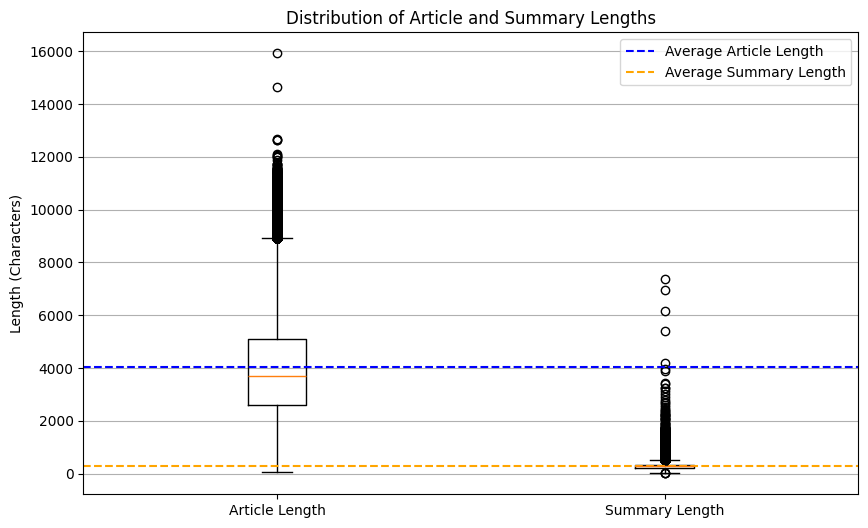

In [ ]:
plt.figure(figsize=(10, 6))
plt.boxplot([train_data['article_length'], train_data['summary_length']], labels=['Article Length', 'Summary Length'])
plt.title('Distribution of Article and Summary Lengths')
plt.ylabel('Length (Characters)')
plt.grid(axis='y')

# إضافة خط للمتوسط
plt.axhline(train_data['article_length'].mean(), color='blue', linestyle='--', label='Average Article Length')
plt.axhline(train_data['summary_length'].mean(), color='orange', linestyle='--', label='Average Summary Length')
plt.legend()
plt.show()

In [ ]:
print("Sample data:")
sample_data = train_data[['article', 'highlights']].sample(5)
for index, row in sample_data.iterrows():
    print(f"Article {index + 1}: {row['article']}\nSummary: {row['highlights']}\n")

Sample data:
Article 167668: By . Ted Thornhill . PUBLISHED: . 09:33 EST, 7 October 2013 . | . UPDATED: . 11:46 EST, 7 October 2013 . An elderly British couple have been knocked down and killed in America whilst trying to cross a five lane freeway in America to reach a roadside diner. Edward McElroy, 76, and his 70-year old wife Brenda were thought to have been walking hand-in-hand when they were hit by a pick-up truck - just 24 hours after they arrived in the US for a last-minute 'fly drive' holiday. A nurse attempted to give first aid to the couple, but both were pronounced dead at the scene having been killed instantly. Tragedy: Brenda and Edward McElroy from Blackpool, Lancashire, who have been killed in a horror crash while on holiday in America . Retired loss adjuster Mr McElroy, known as Ted, and his wife, a former customer services advisor, had travelled to West Virginia where ‘leaf peepers’ were visiting to marvel at the changing colours of the tree-filled landscapes in Autumn

# المرحلة الأولى: التحضير المسبق للنصوص (Preprocessing)





# تنظيف النصوص (Text Cleaning)

In [ ]:

# إزالة النصوص المفقودة
train_data.dropna(inplace=True)
test_data.dropna(inplace=True)
validation_data.dropna(inplace=True)

# تنظيف النصوص من الرموز غير المرغوب فيها
def clean_text(text):
    text = re.sub(r'\s+', ' ', text)  # إزالة المسافات الزائدة
    text = re.sub(r'[^\w\s.,]', '', text)  # إزالة الرموز
    text = re.sub(r'<[^>]*>', '', text)  # إزالة علامات HTML
    text = re.sub(r'[^\x00-\x7F]+', ' ', text)  # إزالة الأحرف غير ASCII
    text = text.strip()  # إزالة المسافات في البداية والنهاية
    return text

# تنظيف النصوص والمُلخصات
train_data['article_cleaned'] = train_data['article'].apply(clean_text)
train_data['summary_cleaned'] = train_data['highlights'].apply(clean_text)

# تنظيف النصوص والمُلخصات
test_data['article_cleaned'] = test_data['article'].apply(clean_text)
test_data['summary_cleaned'] = test_data['highlights'].apply(clean_text)

# تنظيف النصوص والمُلخصات
validation_data['article_cleaned'] = validation_data['article'].apply(clean_text)
validation_data['summary_cleaned'] = validation_data['highlights'].apply(clean_text)

# عرض عينة من البيانات بعد التنظيف
print("Cleaned sample:")
print(train_data[['article_cleaned', 'summary_cleaned']].sample(5))
print(test_data[['article_cleaned', 'summary_cleaned']].sample(5))
print(validation_data[['article_cleaned', 'summary_cleaned']].sample(5))


Cleaned sample:
                                          article_cleaned  \
222151  Change Iain Duncan Smith, pictured, said the b...   
108058  CNN  Northern Irelands top police officer on S...   
85808   The name Brabham could return to Formula One i...   
225847  An effort by the Library of Congress to archiv...   
267074  By . Becky Barrow . Holding on to it Figures f...   

                                          summary_cleaned  
222151  Mr Duncan Smith Everyone should be part of Bri...  
108058  NEW Those people had no intention of peaceful ...  
85808   David Brabham said he planned to use crowdfund...  
225847  Library of Congress has compiled more than 170...  
267074  Net lending has fallen 4.3billion since Februa...  
                                         article_cleaned  \
93     Cristiano Ronaldo looked in formidable form as...   
5148   A timewarp home which has remained unchanged s...   
8281   CNNThe onslaught on Houthis rebels in Yemen co...   
1931   As a young

In [ ]:
# إزالة الجمل المكررة داخل النص
def remove_repeated_sentences(text):
    sentences = text.split('. ')
    unique_sentences = list(dict.fromkeys(sentences))  # الاحتفاظ فقط بالجمل الفريدة
    return '. '.join(unique_sentences)

# تطبيق إزالة التكرار
train_data['article_cleaned'] = train_data['article_cleaned'].apply(remove_repeated_sentences)
train_data['summary_cleaned'] = train_data['summary_cleaned'].apply(remove_repeated_sentences)

test_data['article_cleaned'] = test_data['article_cleaned'].apply(remove_repeated_sentences)
test_data['summary_cleaned'] = test_data['summary_cleaned'].apply(remove_repeated_sentences)

validation_data['article_cleaned'] = validation_data['article_cleaned'].apply(remove_repeated_sentences)
validation_data['summary_cleaned'] = validation_data['summary_cleaned'].apply(remove_repeated_sentences)

# عرض عينة من البيانات بعد التنظيف
print("Cleaned sample:")
print(train_data[['article_cleaned', 'summary_cleaned']].sample(5))

# عرض عينة من البيانات بعد التنظيف
print("Cleaned sample:")
print(test_data[['article_cleaned', 'summary_cleaned']].sample(5))

# عرض عينة من البيانات بعد التنظيف
print("Cleaned sample:")
print(validation_data[['article_cleaned', 'summary_cleaned']].sample(5))


Cleaned sample:
                                          article_cleaned  \
136458  With their faces smeared with boot polish thes...   
239185  Entertainment Weekly  Dan Browns The Da Vinci ...   
92716   By . Helen Pow . PUBLISHED . 0356 EST, 9 Octob...   
278393  By . MailOnline Reporter . Coffee giant Starbu...   
44514   By . Daily Mail Reporter . PUBLISHED . 1355 ES...   

                                          summary_cleaned  
136458  The elite commando unit was made up of America...  
239185  EW Dan Browns new novel, The Lost Symbol, does...  
92716   Mick McDonald, 50, converted a rusty old VW ca...  
278393  The company has spent years denying it sends p...  
44514   Young people dont tend to be fans of bones, KF...  
Cleaned sample:
                                         article_cleaned  \
11025  A young mother and her three children have bee...   
6938   Patients who always see the same GP are more l...   
5674   CNNNorth Korea is in the headlines again. Acco...   
1

In [ ]:
# تحويل النصوص إلى حروف صغيرة
train_data['article_cleaned'] = train_data['article_cleaned'].str.lower()
train_data['summary_cleaned'] = train_data['summary_cleaned'].str.lower()

test_data['article_cleaned'] = test_data['article_cleaned'].str.lower()
test_data['summary_cleaned'] = test_data['summary_cleaned'].str.lower()

validation_data['article_cleaned'] = validation_data['article_cleaned'].str.lower()
validation_data['summary_cleaned'] = validation_data['summary_cleaned'].str.lower()

# عرض عينة من البيانات بعد التنظيف
print("Cleaned sample:")
print(train_data[['article_cleaned', 'summary_cleaned']].sample(5))

# عرض عينة من البيانات بعد التنظيف
print("Cleaned sample:")
print(test_data[['article_cleaned', 'summary_cleaned']].sample(5))

# عرض عينة من البيانات بعد التنظيف
print("Cleaned sample:")
print(validation_data[['article_cleaned', 'summary_cleaned']].sample(5))



Cleaned sample:
                                          article_cleaned  \
278297  cnn  ballistic ecks vs. sever had few fans upo...   
96576   cnn  the big lebowski, ferris buellers day off...   
18429   by . luke salkeld . published . 1016 est, 4 ju...   
169450  an oregon mother says she got sick after eatin...   
134041  new haven, connecticut cnn  a connecticut doct...   

                                          summary_cleaned  
278297  rottentomatoes.com ranked 100 worst films of t...  
96576   the national film registry has added 25 more t...  
18429   graham ovenden, 70, molested young girls he us...  
169450  miranda fischer, 34, claims she caught norovir...  
134041  new police sergeant says he saw hayes fleeing ...  
Cleaned sample:
                                        article_cleaned  \
5474  kristen bell, the voice of frozens anna and th...   
239   arsenal midfielder santi cazorla is among a nu...   
3755  it was a simple slip of the tongue, instantly ...   
5440 

In [ ]:
# إزالة الروابط
def remove_urls(text):
    return re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)

# تطبيق إزالة الروابط
train_data['article_cleaned'] = train_data['article_cleaned'].apply(remove_urls)
train_data['summary_cleaned'] = train_data['summary_cleaned'].apply(remove_urls)

# تطبيق إزالة الروابط
test_data['article_cleaned'] = test_data['article_cleaned'].apply(remove_urls)
test_data['summary_cleaned'] = test_data['summary_cleaned'].apply(remove_urls)

# تطبيق إزالة الروابط
validation_data['article_cleaned'] = validation_data['article_cleaned'].apply(remove_urls)
validation_data['summary_cleaned'] = validation_data['summary_cleaned'].apply(remove_urls)

# عرض عينة من البيانات بعد التنظيف
print("Cleaned sample:")
print(train_data[['article_cleaned', 'summary_cleaned']].sample(5))

# عرض عينة من البيانات بعد التنظيف
print("Cleaned sample:")
print(test_data[['article_cleaned', 'summary_cleaned']].sample(5))

# عرض عينة من البيانات بعد التنظيف
print("Cleaned sample:")
print(validation_data[['article_cleaned', 'summary_cleaned']].sample(5))



Cleaned sample:
                                          article_cleaned  \
152898  there was a new haircut and a new role for rah...   
49832   by . hugo gye . published . 1226 est, 12 decem...   
192893  david moyes has been offered a route back into...   
75894   reno, nevada cnn  over and over thursday, pres...   
160437  gilberto martinez was . almost penniless when ...   

                                          summary_cleaned  
152898  raheem sterling played as a lone striker again...  
49832   fran ikin and peter mortin paid builder 7,000 ...  
192893  david moyes has been out of work since being s...  
75894   president obama holds his third town hallstyle...  
160437  gilberto martinez suarez is wanted on major cr...  
Cleaned sample:
                                         article_cleaned  \
11082  cnnmost days, 16yearold jason zobott walks int...   
5123   cnnthe bad news for rio de janeiro ahead of th...   
4140   airline rivals ryanair and aer lingus have loc...   
5

In [ ]:
# توحيد المسافات
train_data['article_cleaned'] = train_data['article_cleaned'].apply(lambda x: re.sub(r'\s+', ' ', x).strip())
train_data['summary_cleaned'] = train_data['summary_cleaned'].apply(lambda x: re.sub(r'\s+', ' ', x).strip())

test_data['article_cleaned'] = test_data['article_cleaned'].apply(lambda x: re.sub(r'\s+', ' ', x).strip())
test_data['summary_cleaned'] = test_data['summary_cleaned'].apply(lambda x: re.sub(r'\s+', ' ', x).strip())

validation_data['article_cleaned'] = validation_data['article_cleaned'].apply(lambda x: re.sub(r'\s+', ' ', x).strip())
validation_data['summary_cleaned'] = validation_data['summary_cleaned'].apply(lambda x: re.sub(r'\s+', ' ', x).strip())

# عرض عينة من البيانات بعد التنظيف
print("Cleaned sample:")
print(train_data[['article_cleaned', 'summary_cleaned']].sample(5))

# عرض عينة من البيانات بعد التنظيف
print("Cleaned sample:")
print(test_data[['article_cleaned', 'summary_cleaned']].sample(5))

# عرض عينة من البيانات بعد التنظيف
print("Cleaned sample:")
print(validation_data[['article_cleaned', 'summary_cleaned']].sample(5))



Cleaned sample:
                                          article_cleaned  \
236004  january 9 , 2015 . cnn student news wraps up t...   
225659  by . rob cooper . published . 0720 est, 28 nov...   
157613  cnn simba makoni, the former zimbabwean financ...   
173525  by . james chapman . published . 1903 est, 6 j...   
254936  mps are demanding a bigger expenses bill so th...   

                                          summary_cleaned  
236004  this page includes the show transcript . use t...  
225659  francesca and elisabetta grillo spent 685,000 ...  
157613  simba makoni is a zimbabwean politician who ra...  
173525  proposal is at the heart of a new coalition de...  
254936  commons watchdog launches review of expenses r...  
Cleaned sample:
                                        article_cleaned  \
3108  gerard pique and charttopper shakira were in t...   
7739  a 73yearold man is to appear in court today ch...   
2492  dope smokers beware if marco rubio or chris ch...   
3742 

In [ ]:

stop_words = set(stopwords.words('english'))

# إزالة الكلمات الشائعة
def remove_stop_words(text):
    words = text.split()
    filtered_words = [word for word in words if word not in stop_words]
    return ' '.join(filtered_words)

# تطبيق إزالة الكلمات الشائعة
train_data['article_cleaned'] = train_data['article_cleaned'].apply(remove_stop_words)
train_data['summary_cleaned'] = train_data['summary_cleaned'].apply(remove_stop_words)

test_data['article_cleaned'] = test_data['article_cleaned'].apply(remove_stop_words)
test_data['summary_cleaned'] = test_data['summary_cleaned'].apply(remove_stop_words)

validation_data['article_cleaned'] = validation_data['article_cleaned'].apply(remove_stop_words)
validation_data['summary_cleaned'] = validation_data['summary_cleaned'].apply(remove_stop_words)

# عرض عينة من البيانات بعد التنظيف
print("Cleaned sample:")
print(train_data[['article_cleaned', 'summary_cleaned']].sample(5))

# عرض عينة من البيانات بعد التنظيف
print("Cleaned sample:")
print(test_data[['article_cleaned', 'summary_cleaned']].sample(5))

# عرض عينة من البيانات بعد التنظيف
print("Cleaned sample:")
print(validation_data[['article_cleaned', 'summary_cleaned']].sample(5))




Cleaned sample:
                                          article_cleaned  \
123185  . kerry mcdermott . published . 0454 est, 20 f...   
14808   haitis terror didnt end ground stopped shaking...   
203351  mps embroiled yet another expenses row today e...   
24305   warsaw, poland cnn polands interim president b...   
150890  cnn horseback riders braving rugged idaho wild...   

                                          summary_cleaned  
123185  warning images contain graphic content . femal...  
14808   nearly three years haitis earthquake, many sti...  
203351  defence secretary liam fox, shadow ministers a...  
24305   new interim president bronislaw komorowski win...  
150890  demeanor expressions place, rider says . girl ...  
Cleaned sample:
                                         article_cleaned  \
7200   question personal discuss even closest friends...   
10751  chelsea midfielder eden hazard toast english g...   
8914   finding discounted flights tends hit miss vaca...   
6

In [ ]:
# إعادة حساب الأطوال بعد التنظيف
train_data['article_cleaned_length'] = train_data['article_cleaned'].apply(len)
train_data['summary_cleaned_length'] = train_data['summary_cleaned'].apply(len)

test_data['article_cleaned_length'] = test_data['article_cleaned'].apply(len)
test_data['summary_cleaned_length'] = test_data['summary_cleaned'].apply(len)

validation_data['article_cleaned_length'] = validation_data['article_cleaned'].apply(len)
validation_data['summary_cleaned_length'] = validation_data['summary_cleaned'].apply(len)

# عرض إحصائيات الأطوال بعد التنظيف
print(train_data[['article_cleaned_length', 'summary_cleaned_length']].describe())
print(test_data[['article_cleaned_length', 'summary_cleaned_length']].describe())
print(validation_data[['article_cleaned_length', 'summary_cleaned_length']].describe())


       article_cleaned_length  summary_cleaned_length
count           287113.000000           287113.000000
mean              2883.717390              227.025934
std               1394.829766               89.448057
min                 47.000000               11.000000
25%               1854.000000              170.000000
50%               2628.000000              216.000000
75%               3643.000000              265.000000
max              14569.000000             5837.000000
       article_cleaned_length  summary_cleaned_length
count            11490.000000            11490.000000
mean              2807.879112              237.495735
std               1437.361535               94.835219
min                191.000000               40.000000
25%               1720.000000              177.000000
50%               2509.000000              222.000000
75%               3577.750000              273.000000
max              10230.000000             2948.000000
       article_cleaned_lengt

In [ ]:
print("Cleaned train sample after all processing:")
print(train_data[['article_cleaned', 'summary_cleaned']].sample(5))

print("Cleaned test sample after all processing:")
print(test_data[['article_cleaned', 'summary_cleaned']].sample(5))

print("Cleaned validation sample after all processing:")
print(validation_data[['article_cleaned', 'summary_cleaned']].sample(5))


Cleaned train sample after all processing:
                                          article_cleaned  \
272570  jota cut inside, awful lot on, let fly. crept ...   
259244  . anna edwards . banksy artwork ripped north l...   
272941  fast company ipad changing folks read stuff on...   
12028   schoolboy hanged falsely branded rapist fellow...   
30408   . daily mail reporter . published . 1716 est, ...   

                                          summary_cleaned  
272570  hugo rodallega gave fulham lead 57th minute . ...  
259244  ball games removed wall turnpike lane, tottenh...  
272941  main bulk ipad text content consumption 7 p.m....  
12028   tom acton falsely accused tied girl tree sexua...  
30408   sally roberts, 38, lost legal battle . stop so...  
Cleaned test sample after all processing:
                                        article_cleaned  \
6815  football association contacting qpr chelsea in...   
7302  respected law professor philadelphia investiga...   
6712  world

In [ ]:
# حفظ البيانات المنظفة في ملفات CSV
train_data.to_csv('/content/data/cleaned_train_data.csv', index=False)
test_data.to_csv('/content/data/cleaned_test_data.csv', index=False)
validation_data.to_csv('/content/data/cleaned_validation_data.csv', index=False)

# تجزئة النص (Tokenization)

In [ ]:
train_data = pd.read_csv('/content/data/cleaned_train_data.csv')
test_data = pd.read_csv('/content/data/cleaned_test_data.csv')
validation_data = pd.read_csv('/content/data/cleaned_validation_data.csv')

In [ ]:
# تقسيم النصوص إلى جمل
train_data['article_sentences'] = train_data['article_cleaned'].apply(sent_tokenize)
train_data['summary_sentences'] = train_data['summary_cleaned'].apply(sent_tokenize)

test_data['article_sentences'] = test_data['article_cleaned'].apply(sent_tokenize)
test_data['summary_sentences'] = test_data['summary_cleaned'].apply(sent_tokenize)

validation_data['article_sentences'] = validation_data['article_cleaned'].apply(sent_tokenize)
validation_data['summary_sentences'] = validation_data['summary_cleaned'].apply(sent_tokenize)

# عرض عينة من الجمل
print(train_data[['article_sentences', 'summary_sentences']].sample(5))
print(test_data[['article_sentences', 'summary_sentences']].sample(5))
print(validation_data[['article_sentences', 'summary_sentences']].sample(5))


                                        article_sentences  \
93997   [mexico city, mexico cnn police chief canc n r...   
156132  [aeroplane might first place think looking goo...   
79510   [get excited discovery vintage coat pretty vas...   
164023  [german government said thursday expelling per...   
230357  [strangers act kindness turned fortunes around...   

                                        summary_sentences  
93997   [mexican media says local chief put house arre...  
156132  [retired boeing 457 jumbo jet made 33room jumb...  
79510   [doublesided carved seal found charity shop he...  
164023  [germany stresses mutual trust white house spo...  
230357  [alan barnes disabled born sight growth proble...  
                                       article_sentences  \
3631   [sri lankas kumar sangakkara reconsider decisi...   
3420   [politics teacher 31,000ayear boarding school ...   
616    [highlyanticipated champions league quarterfin...   
10108  [mother demanding 300,000 

In [ ]:
# حساب عدد الجمل في المقالات والملخصات
train_data['article_sentence_count'] = train_data['article_sentences'].apply(len)
train_data['summary_sentence_count'] = train_data['summary_sentences'].apply(len)

test_data['article_sentence_count'] = test_data['article_sentences'].apply(len)
test_data['summary_sentence_count'] = test_data['summary_sentences'].apply(len)

validation_data['article_sentence_count'] = validation_data['article_sentences'].apply(len)
validation_data['summary_sentence_count'] = validation_data['summary_sentences'].apply(len)

# عرض إحصائيات عدد الجمل
print(train_data[['article_sentence_count', 'summary_sentence_count']].describe())

       article_sentence_count  summary_sentence_count
count           287113.000000           287113.000000
mean                37.627631                3.662955
std                 22.545460                1.334332
min                  1.000000                1.000000
25%                 22.000000                3.000000
50%                 32.000000                4.000000
75%                 47.000000                4.000000
max                328.000000              107.000000


In [ ]:
# حساب الأطوال
train_data['article_length'] = train_data['article_cleaned'].apply(len)
train_data['summary_length'] = train_data['summary_cleaned'].apply(len)

# عرض إحصائيات الأطوال
print(train_data[['article_length', 'summary_length']].describe())

       article_length  summary_length
count   287113.000000   287113.000000
mean      2883.717390      227.025934
std       1394.829766       89.448057
min         47.000000       11.000000
25%       1854.000000      170.000000
50%       2628.000000      216.000000
75%       3643.000000      265.000000
max      14569.000000     5837.000000


In [ ]:
# عرض عينة من الجمل للتأكد من الجودة
print(train_data[['article_sentences', 'summary_sentences']].sample(5))

                                        article_sentences  \
165028  [senior cancer specialist today condemned cont...   
144840  [xu caihou, retired pla general former vicecha...   
168945  [cnn matter years away miles separate her, cry...   
164676  [., becky evans ap reporter ., published ., 07...   
65533   [philadelphia, mississippi cnn james young sti...   

                                        summary_sentences  
165028  [wouldnt treated hospital here, says professor...  
144840  [chinese president xi jinping intensifying her...  
168945  [mine disaster shines spotlight community stee...  
164676  [donovan surrounded family died baltimore hosp...  
65533   [philadelphia, mississippi, elects first black...  



#  استخراج المعلومات (Information Extraction)

In [ ]:
pip install scikit-learn nltk spacy

In [ ]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer

# قراءة البيانات
train_data = pd.read_csv('/content/data/cleaned_train_data.csv')  # تأكد من استخدام المسار الصحيح


# استخدام النصوص من مجموعة البيانات
texts = train_data['article_cleaned'].head(5)  # استخدام أول 5 نصوص

# إنشاء نموذج TF-IDF
vectorizer = TfidfVectorizer(stop_words='english')
tfidf_matrix = vectorizer.fit_transform(texts)

# الحصول على الكلمات الرئيسية
feature_names = vectorizer.get_feature_names_out()
dense = tfidf_matrix.todense()

# تحويل المصفوفة الكثيفة إلى DataFrame
df_tfidf = pd.DataFrame(dense, columns=feature_names)

# عرض الكلمات الرئيسية لكل نص
for i in range(len(texts)):
    print(f"Text {i + 1}:")
    df_text = df_tfidf.iloc[i].sort_values(ascending=False)
    print(df_text.head(10))  # عرض أعلى 10 كلمات رئيسية
    print("\n")

Text 1:
fargo        0.328025
diocese      0.328025
hepatitis    0.262420
bishop       0.262420
north        0.196815
dakota       0.196815
catholic     0.196815
october      0.158789
grand        0.131210
jamestown    0.131210
Name: 0, dtype: float64


Text 2:
mata            0.513242
complaint       0.299391
organization    0.256621
drug            0.213851
police          0.172534
miami           0.171081
trafficking     0.128311
according       0.128311
working         0.128311
including       0.103520
Name: 1, dtype: float64


Text 3:
driving          0.383244
ecclestontodd    0.294803
phone            0.265323
collision        0.206362
miss             0.176882
friends          0.176882
mr               0.147402
titley           0.147402
pub              0.147402
mobile           0.147402
Name: 2, dtype: float64


Text 4:
money        0.201409
russia       0.199713
sides        0.199713
europe       0.199713
eu           0.199713
trade        0.149785
russian      0.149785
europe

In [ ]:
import spacy

# تحميل نموذج spaCy
nlp = spacy.load('en_core_web_sm')

# تحليل النصوص لتحديد الأحداث
def extract_events(text):
    doc = nlp(text)
    events = []
    for token in doc:
        if token.pos_ == 'VERB':  # تحديد الأفعال
            subjects = [w for w in token.children if w.dep_ == 'nsubj']
            if subjects:
                for subj in subjects:
                    events.append((subj.text, token.text))  # ربط الفاعل بالحدث
    return events

# استخدام النصوص من مجموعة البيانات
for index, row in train_data.head(5).iterrows():
    text = row['article_cleaned']  # أو استخدم row['summary_cleaned']

    # استخراج الأحداث
    events = extract_events(text)

    print(f"Text {index + 1}: {text}")
    print("Extracted Events:")
    for subj, verb in events:
        print(f"Subject: {subj}, Verb: {verb}")
    print("\n")

Text 1: . associated press . published . 1411 est, 25 october 2013 . . updated . 1536 est, 25 october 2013 . bishop fargo catholic diocese north dakota exposed potentially hundreds church members fargo, grand forks jamestown hepatitis virus late september early october. state health department issued advisory exposure anyone attended five churches took communion. bishop john folda pictured fargo catholic diocese north dakota exposed potentially hundreds church members fargo, grand forks jamestown hepatitis . state immunization program manager molly howell says risk low, officials feel important alert people possible exposure. diocese announced monday bishop john folda taking time diagnosed hepatitis a. diocese says contracted infection contaminated food attending conference newly ordained bishops italy last month. symptoms hepatitis include fever, tiredness, loss appetite, nausea abdominal discomfort. fargo catholic diocese north dakota pictured bishop located .
Extracted Events:
Subje

# unsupervised: توليد الجمل الملخصة (Summary Generation)

In [ ]:
!pip install gensim==3.8.3

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.4/23.4 MB 30.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  error: subprocess-exited-with-error
  
  × python setup.py bdist_wheel did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  ERROR: Failed building wheel for gensim
  Running setup.py clean for gensim
Failed to build gensim
ERROR: ERROR: Failed to build installable wheels for some pyproject.toml based projects (gensim)


In [ ]:
pip install sumy

بطريقة sumy

In [ ]:
from sumy.parsers.plaintext import PlaintextParser
from sumy.nlp.tokenizers import Tokenizer
from sumy.summarizers.text_rank import TextRankSummarizer

# تلخيص النصوص باستخدام sumy
for index, row in train_data.head(5).iterrows():
    text = row['article_cleaned']  # أو استخدم row['summary_cleaned']

    parser = PlaintextParser.from_string(text, Tokenizer("english"))
    summarizer = TextRankSummarizer()

    summary = summarizer(parser.document, 3)  # ملخص يتكون من 3 جمل
    print(f"Text {index + 1} Summary:")
    for sentence in summary:
        print(sentence)
    print("\n")

Text 1 Summary:
bishop fargo catholic diocese north dakota exposed potentially hundreds church members fargo, grand forks jamestown hepatitis virus late september early october.
bishop john folda pictured fargo catholic diocese north dakota exposed potentially hundreds church members fargo, grand forks jamestown hepatitis .
diocese announced monday bishop john folda taking time diagnosed hepatitis a. diocese says contracted infection contaminated food attending conference newly ordained bishops italy last month.


Text 2 Summary:
criminal complaint unsealed u.s. district court new jersey tuesday accuses mata, also known milk man, using role police officer help drug trafficking organization exchange money gifts, including rolex watch.
court documents released investigators specify name drug trafficking organization mata allegedly conspired says organization importing narcotics places ecuador dominican republic hiding inside shipping containers containing pallets produce, including banan

بطريقة LSA

In [ ]:
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import TfidfVectorizer

# تلخيص النصوص باستخدام LSA
def summarize_lsa(texts, num_sentences=3):
    vectorizer = TfidfVectorizer(stop_words='english')
    X = vectorizer.fit_transform(texts)

    # تطبيق LSA
    svd = TruncatedSVD(n_components=5)  # يمكن تعديل العدد حسب الحاجة
    svd.fit(X)

    # الحصول على الكلمات الأكثر أهمية
    terms = vectorizer.get_feature_names_out()
    sentences = texts[0].split('. ')

    # ترتيب الجمل حسب الوزن
    sentence_weights = []
    for i, sentence in enumerate(sentences):
        weight = sum(svd.components_[0][vectorizer.transform([sentence]).nonzero()[1]])
        sentence_weights.append((weight, sentence))

    # اختيار الجمل الأكثر أهمية
    top_sentences = sorted(sentence_weights, reverse=True)[:num_sentences]
    return ' '.join(sentence for _, sentence in top_sentences)

# تلخيص النصوص
for index, row in train_data.head(5).iterrows():
    text = row['article_cleaned']  # أو استخدم row['summary_cleaned']

    # استخدام LSA للتلخيص
    lsa_summary = summarize_lsa([text])
    print(f"Text {index + 1} LSA Summary:")
    print(lsa_summary)
    print("\n")

Text 1 LSA Summary:
bishop fargo catholic diocese north dakota exposed potentially hundreds church members fargo, grand forks jamestown hepatitis virus late september early october bishop john folda pictured fargo catholic diocese north dakota exposed potentially hundreds church members fargo, grand forks jamestown hepatitis  fargo catholic diocese north dakota pictured bishop located .


Text 2 LSA Summary:
district court new jersey tuesday accuses mata, also known milk man, using role police officer help drug trafficking organization exchange money gifts, including rolex watch court documents released investigators specify name drug trafficking organization mata allegedly conspired says organization importing narcotics places ecuador dominican republic hiding inside shipping containers containing pallets produce, including bananas mata worked miamidade police department since 1992, including directing investigations miami gardens working lieutenant k9 unit miami international airport

In [ ]:
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import TfidfVectorizer
import pandas as pd
#lsa 2
# دالة تلخيص النصوص باستخدام LSA
def summarize_lsa(texts, num_sentences=3):
    """
    تلخيص النصوص باستخدام تحليل LSA.

    Args:
        texts (list): قائمة بالنصوص (نص واحد أو أكثر).
        num_sentences (int): عدد الجمل المطلوبة في الملخص.

    Returns:
        str: النص الملخص.
    """
    # إنشاء TF-IDF
    vectorizer = TfidfVectorizer(stop_words='english')
    X = vectorizer.fit_transform(texts)

    # تطبيق LSA باستخدام TruncatedSVD
    svd = TruncatedSVD(n_components=5)  # عدد المكونات يمكن تعديله حسب النصوص
    svd.fit(X)

    # استخراج الجمل من النص
    sentences = texts[0].split('. ')

    # حساب الوزن لكل جملة
    sentence_weights = []
    for sentence in sentences:
        sentence_vector = vectorizer.transform([sentence])
        weight = svd.components_[0][sentence_vector.nonzero()[1]].sum()
        sentence_weights.append((weight, sentence))

    # ترتيب الجمل حسب الوزن واختيار الأكثر أهمية
    top_sentences = sorted(sentence_weights, key=lambda x: x[0], reverse=True)[:num_sentences]
    top_sentences = sorted(top_sentences, key=lambda x: sentences.index(x[1]))  # للحفاظ على ترتيب النص الأصلي

    # إعادة الجمل الأكثر أهمية كنص ملخص
    return ' '.join(sentence for _, sentence in top_sentences)


# تلخيص النصوص من ملف
if __name__ == "__main__":
    # قراءة الملف
    file_path = "/content/data/cleaned_train_data.csv"  # استبدل هذا بمسار ملفك
    column_name = "article_cleaned"  # اسم العمود الذي يحتوي على النصوص

    # تحميل البيانات
    try:
        train_data = pd.read_csv(file_path)

        # التحقق من وجود العمود المطلوب
        if column_name not in train_data.columns:
            raise ValueError(f"Column '{column_name}' not found in the file.")

        # تلخيص أول 5 نصوص
        for index, row in train_data.head(5).iterrows():
            text = row[column_name]
            lsa_summary = summarize_lsa([text])
            print(f"Text {index + 1} LSA Summary:")
            print(lsa_summary)
            print("\n")

    except FileNotFoundError:
        print(f"Error: The file '{file_path}' was not found.")
    except Exception as e:
        print(f"An error occurred: {e}")


/usr/local/lib/python3.10/dist-packages/sklearn/decomposition/_truncated_svd.py:273: RuntimeWarning: invalid value encountered in divide
  self.explained_variance_ratio_ = exp_var / full_var


Text 1 LSA Summary:
bishop fargo catholic diocese north dakota exposed potentially hundreds church members fargo, grand forks jamestown hepatitis virus late september early october bishop john folda pictured fargo catholic diocese north dakota exposed potentially hundreds church members fargo, grand forks jamestown hepatitis 


Text 2 LSA Summary:
district court new jersey tuesday accuses mata, also known milk man, using role police officer help drug trafficking organization exchange money gifts, including rolex watch court documents released investigators specify name drug trafficking organization mata allegedly conspired says organization importing narcotics places ecuador dominican republic hiding inside shipping containers containing pallets produce, including bananas


Text 3 LSA Summary:
mr ecclestontodd took decision pick mobile phone whilst driving and, either reading replying text message, distracted failed negotiate lefthand bend, crossing central white line path miss titleys

#  unsupervised: تقييم الملخصات (Evaluation)

In [ ]:
pip install rouge-score


In [ ]:
pip install rouge


LSA Evaluation

In [ ]:
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import TfidfVectorizer
from rouge_score import rouge_scorer
import pandas as pd

# تلخيص النصوص باستخدام LSA
def summarize_lsa(texts, num_sentences=3):
    vectorizer = TfidfVectorizer(stop_words='english')
    X = vectorizer.fit_transform(texts)

    # تطبيق LSA
    svd = TruncatedSVD(n_components=5)  # يمكن تعديل العدد حسب الحاجة
    svd.fit(X)

    # الحصول على الكلمات الأكثر أهمية
    terms = vectorizer.get_feature_names_out()
    sentences = texts[0].split('. ')

    # ترتيب الجمل حسب الوزن
    sentence_weights = []
    for i, sentence in enumerate(sentences):
        weight = sum(svd.components_[0][vectorizer.transform([sentence]).nonzero()[1]])
        sentence_weights.append((weight, sentence))

    # اختيار الجمل الأكثر أهمية
    top_sentences = sorted(sentence_weights, reverse=True)[:num_sentences]
    return ' '.join(sentence for _, sentence in top_sentences)

# حساب ROUGE
def evaluate_with_rouge(predicted, reference):
    scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)
    scores = scorer.score(reference, predicted)
    return scores

# تحميل البيانات
file_path = '/content/data/cleaned_train_data.csv'  # استبدل بمسار ملفك
train_data = pd.read_csv(file_path)

# تخزين التقييم
rouge_results = []

# التقييم على أول 5 نصوص
for index, row in train_data.head(5).iterrows():
    text = row['article_cleaned']  # النصوص الأصلية
    reference_summary = row['summary_cleaned']  # النصوص المرجعية

    # تلخيص باستخدام LSA
    lsa_summary = summarize_lsa([text])

    # تقييم باستخدام ROUGE
    rouge_score = evaluate_with_rouge(lsa_summary, reference_summary)
    rouge_results.append(rouge_score)

    # عرض النتائج
    print(f"Text {index + 1} LSA Summary:")
    print(lsa_summary)
    print("ROUGE Scores:", rouge_score)
    print("\n")


# عرض المتوسطات النهائية
avg_rouge1 = sum(r['rouge1'].fmeasure for r in rouge_results) / len(rouge_results)
avg_rouge2 = sum(r['rouge2'].fmeasure for r in rouge_results) / len(rouge_results)
avg_rougeL = sum(r['rougeL'].fmeasure for r in rouge_results) / len(rouge_results)

print("Average ROUGE Scores:")
print(f"ROUGE-1: {avg_rouge1:.4f}")
print(f"ROUGE-2: {avg_rouge2:.4f}")
print(f"ROUGE-L: {avg_rougeL:.4f}")


/usr/local/lib/python3.10/dist-packages/sklearn/decomposition/_truncated_svd.py:273: RuntimeWarning: invalid value encountered in divide
  self.explained_variance_ratio_ = exp_var / full_var


Text 1 LSA Summary:
bishop fargo catholic diocese north dakota exposed potentially hundreds church members fargo, grand forks jamestown hepatitis virus late september early october bishop john folda pictured fargo catholic diocese north dakota exposed potentially hundreds church members fargo, grand forks jamestown hepatitis  fargo catholic diocese north dakota pictured bishop located .
ROUGE Scores: {'rouge1': Score(precision=0.25, recall=0.5714285714285714, fmeasure=0.34782608695652173), 'rouge2': Score(precision=0.1702127659574468, recall=0.4, fmeasure=0.23880597014925373), 'rougeL': Score(precision=0.22916666666666666, recall=0.5238095238095238, fmeasure=0.31884057971014496)}


Text 2 LSA Summary:
district court new jersey tuesday accuses mata, also known milk man, using role police officer help drug trafficking organization exchange money gifts, including rolex watch court documents released investigators specify name drug trafficking organization mata allegedly conspired says org

sumy Evaluate

In [ ]:
from sumy.parsers.plaintext import PlaintextParser
from sumy.nlp.tokenizers import Tokenizer
from sumy.summarizers.text_rank import TextRankSummarizer
from rouge import Rouge
import pandas as pd

# تحميل البيانات
train_data = pd.read_csv('/content/data/cleaned_train_data.csv')

# إنشاء كائن ROUGE
rouge = Rouge()

# قائمة لتخزين النتائج
results = []

# تلخيص النصوص وتقييمها
for index, row in train_data.head(5).iterrows():
    # النص الأصلي والملخص المرجعي
    text = row['article_cleaned']
    reference_summary = row['summary_cleaned']

    # تلخيص باستخدام sumy
    parser = PlaintextParser.from_string(text, Tokenizer("english"))
    summarizer = TextRankSummarizer()
    summary_sentences = summarizer(parser.document, 3)  # تلخيص من 3 جمل
    generated_summary = " ".join(str(sentence) for sentence in summary_sentences)  # تحويل الجمل إلى نص واحد

    # حساب ROUGE
    scores = rouge.get_scores(generated_summary, reference_summary, avg=True)

    # تخزين النتائج
    results.append({
        "Text Index": index + 1,
        "ROUGE-1": scores['rouge-1']['f'],
        "ROUGE-2": scores['rouge-2']['f'],
        "ROUGE-L": scores['rouge-l']['f']
    })

# تحويل النتائج إلى DataFrame
results_df = pd.DataFrame(results)

# عرض النتائج
print(results_df)

# حساب المتوسطات
average_scores = results_df.mean()
print("\nAverage ROUGE Scores:")
print(f"ROUGE-1: {average_scores['ROUGE-1']:.4f}")
print(f"ROUGE-2: {average_scores['ROUGE-2']:.4f}")
print(f"ROUGE-L: {average_scores['ROUGE-L']:.4f}")


   Text Index   ROUGE-1   ROUGE-2   ROUGE-L
0           1  0.562500  0.323529  0.531250
1           2  0.147368  0.019417  0.147368
2           3  0.341880  0.147541  0.290598
3           4  0.077670  0.000000  0.077670
4           5  0.135593  0.016667  0.118644

Average ROUGE Scores:
ROUGE-1: 0.2530
ROUGE-2: 0.1014
ROUGE-L: 0.2331


**cosain similarety Evaluation**

LSA

In [ ]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.decomposition import TruncatedSVD

# دالة تلخيص النصوص باستخدام LSA
def summarize_lsa(texts, num_sentences=3):
    vectorizer = TfidfVectorizer(stop_words='english')
    X = vectorizer.fit_transform(texts)

    # تطبيق LSA
    svd = TruncatedSVD(n_components=5)
    svd.fit(X)

    # تقسيم النص إلى جمل
    sentences = texts[0].split('. ')

    # حساب الوزن لكل جملة
    sentence_weights = []
    for sentence in sentences:
        weight = sum(svd.components_[0][vectorizer.transform([sentence]).nonzero()[1]])
        sentence_weights.append((weight, sentence))

    # اختيار الجمل الأكثر أهمية
    top_sentences = sorted(sentence_weights, key=lambda x: x[0], reverse=True)[:num_sentences]
    return ' '.join(sentence for _, sentence in top_sentences)

# دالة حساب التشابه باستخدام Cosine Similarity
def content_based_evaluation(original_texts, generated_summaries):
    vectorizer = TfidfVectorizer(stop_words='english')
    all_texts = original_texts + generated_summaries
    tfidf_matrix = vectorizer.fit_transform(all_texts)

    # فصل متجهات النصوص الأصلية والملخصات
    original_vectors = tfidf_matrix[:len(original_texts)]
    generated_vectors = tfidf_matrix[len(original_texts):]

    # حساب التشابه الكوني
    similarities = cosine_similarity(original_vectors, generated_vectors)
    avg_similarity = similarities.diagonal().mean()  # متوسط التشابه بين النصوص الأصلية والملخصات
    return avg_similarity

# قراءة البيانات من ملف
file_path = "/content/data/cleaned_train_data.csv"  # استبدل بمسار ملفك
data = pd.read_csv(file_path)

# التأكد من وجود الأعمدة المطلوبة
assert 'article_cleaned' in data.columns, "Column 'article_cleaned' not found in the dataset"
assert 'summary_cleaned' in data.columns, "Column 'summary_cleaned' not found in the dataset"

# استخدام أول 5 نصوص فقط
data_subset = data.head(5)
original_texts = data_subset['article_cleaned'].tolist()
reference_summaries = data_subset['summary_cleaned'].tolist()

# توليد الملخصات باستخدام LSA
generated_summaries = []
for text in original_texts:
    lsa_summary = summarize_lsa([text])
    generated_summaries.append(lsa_summary)

# تقييم Content-Based
similarity_score = content_based_evaluation(original_texts, generated_summaries)
print(f"Content-Based Evaluation (Cosine Similarity): {similarity_score:.4f}")

# طباعة أمثلة للمقارنة
for i in range(len(data_subset)):  # طباعة النصوص والملخصات لأول 5 فقط
    print(f"Original Text {i + 1}: {original_texts[i]}")
    print(f"Reference Summary {i + 1}: {reference_summaries[i]}")
    print(f"Generated Summary {i + 1}: {generated_summaries[i]}")
    print("\n")


Content-Based Evaluation (Cosine Similarity): 0.6390
Original Text 1: . associated press . published . 1411 est, 25 october 2013 . . updated . 1536 est, 25 october 2013 . bishop fargo catholic diocese north dakota exposed potentially hundreds church members fargo, grand forks jamestown hepatitis virus late september early october. state health department issued advisory exposure anyone attended five churches took communion. bishop john folda pictured fargo catholic diocese north dakota exposed potentially hundreds church members fargo, grand forks jamestown hepatitis . state immunization program manager molly howell says risk low, officials feel important alert people possible exposure. diocese announced monday bishop john folda taking time diagnosed hepatitis a. diocese says contracted infection contaminated food attending conference newly ordained bishops italy last month. symptoms hepatitis include fever, tiredness, loss appetite, nausea abdominal discomfort. fargo catholic diocese 

/usr/local/lib/python3.10/dist-packages/sklearn/decomposition/_truncated_svd.py:273: RuntimeWarning: invalid value encountered in divide
  self.explained_variance_ratio_ = exp_var / full_var


sumy

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sumy.parsers.plaintext import PlaintextParser
from sumy.nlp.tokenizers import Tokenizer
from sumy.summarizers.text_rank import TextRankSummarizer
import pandas as pd

# دالة لحساب Cosine Similarity بين النصين
def calculate_cosine_similarity(text1, text2):
    vectorizer = TfidfVectorizer(stop_words='english')
    # دمج النصين للحصول على تمثيل مشترك
    tfidf_matrix = vectorizer.fit_transform([text1, text2])
    return cosine_similarity(tfidf_matrix[0:1], tfidf_matrix[1:2])[0][0]

# تلخيص النصوص باستخدام TextRank وتقييمها باستخدام Cosine Similarity
for index, row in train_data.head(5).iterrows():
    text = row['article_cleaned']  # النص الأصلي
    true_summary = row['summary_cleaned']  # الملخص الموجود في البيانات

    # تطبيق TextRank على النص
    parser = PlaintextParser.from_string(text, Tokenizer("english"))
    summarizer = TextRankSummarizer()
    summary = summarizer(parser.document, 3)  # ملخص يتكون من 3 جمل

    # جمع الجمل في الملخص الذي تولده الخوارزمية
    generated_summary = ' '.join([str(sentence) for sentence in summary])

    # حساب الـ Cosine Similarity بين الملخص الناتج والملخص الموجود في البيانات
    cosine_sim = calculate_cosine_similarity(generated_summary, true_summary)

    # طباعة النتيجة
    print(f"Text {index + 1} Summary (Generated):")
    print(generated_summary)
    print(f"True Summary: {true_summary}")
    print(f"Cosine Similarity between Generated and True Summary: {cosine_sim:.4f}")
    print("\n")


Text 1 Summary (Generated):
bishop fargo catholic diocese north dakota exposed potentially hundreds church members fargo, grand forks jamestown hepatitis virus late september early october. bishop john folda pictured fargo catholic diocese north dakota exposed potentially hundreds church members fargo, grand forks jamestown hepatitis . diocese announced monday bishop john folda taking time diagnosed hepatitis a. diocese says contracted infection contaminated food attending conference newly ordained bishops italy last month.
True Summary: bishop john folda, north dakota, taking time diagnosed . contracted infection contaminated food italy . church members fargo, grand forks jamestown could exposed .
Cosine Similarity between Generated and True Summary: 0.5904


Text 2 Summary (Generated):
criminal complaint unsealed u.s. district court new jersey tuesday accuses mata, also known milk man, using role police officer help drug trafficking organization exchange money gifts, including rolex 

# Supervised

# **استخراج الميزات**

In [ ]:
import pandas as pd
import nltk
from nltk.tokenize import sent_tokenize, word_tokenize

# تحميل مكتبة nltk
nltk.download('punkt')

# قراءة ملف CSV
file_path = '/content/data/cleaned_train_data.csv'  # استبدل بمسار ملفك
df = pd.read_csv(file_path)

# التحقق من وجود العمود الذي يحتوي النصوص
text_column = 'article_cleaned'  # استبدل باسم العمود الذي يحتوي النصوص
if text_column not in df.columns:
    raise ValueError(f"العمود '{text_column}' غير موجود في الملف")

# التوكنة على مستوى الجملة وحساب الأطوال
sentence_lengths = []

for text in df[text_column]:
    sentences = sent_tokenize(text)  # تقسيم النص إلى جمل
    for sentence in sentences:
        tokenized_words = word_tokenize(sentence)  # تقسيم الجملة إلى كلمات
        sentence_lengths.append({'sentence': sentence, 'length': len(tokenized_words)})

# تحويل النتائج إلى DataFrame
lengths_df = pd.DataFrame(sentence_lengths)

# حفظ النتائج إلى ملف جديد
lengths_df.to_csv('sentence_lengths.csv', index=False)

print(lengths_df.head(5))


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


                      sentence  length
0                            .       1
1           associated press .       3
2                  published .       2
3  1411 est, 25 october 2013 .       7
4                            .       1


In [ ]:
# العثور على أطول 10 جمل
top_10_sentences = sorted(sentence_lengths, key=lambda x: x['length'], reverse=True)[:10]

# عرض النتائج
print("أطول 10 جمل مع أطوالها:")
for i, sentence_data in enumerate(top_10_sentences, 1):
    print(f"{i}. الجملة: {sentence_data['sentence']}")
    print(f"   الطول: {sentence_data['length']}")


أطول 10 جمل مع أطوالها:
1. الجملة: michael j. milia, 34, garden city, new york ruben m. gomez, 45, wesbury, new york robert kittelberger, 46, wantagh, new york judd lesser, 50, lawrence, new york jaspreet singh, 20, bellerose, new york louis dimaria, 38, manhasset, new york christian flizzola, 23, mineola, new york mario lucio, 47, mineola, new york arnold j. sean, 19, uniondale, new york jeremy j. moore, 38, freeport, new york leon reginald tarver iii, 35, uniondale, new york mark r. hader, 53, glen head, new york john j. leon, 53, new hyde park, new york gary h. friedenberg, 72, melville, new york david m. knott jr., 28, mill neck, new york harjot singh, 28, hicksville, new york ronald h. haeseker, 51, north merrick, new york herbert j. mccooey, 31, garden city south, new york jonathon s. vega, 29, long beach, new york david bennett, 28, merrick, new york hildago canales, 23, westbury, new york william smith, 36, wantagh, new york scott w. manning, 44, oceanside, new york adrian lama

سحابة كلمات

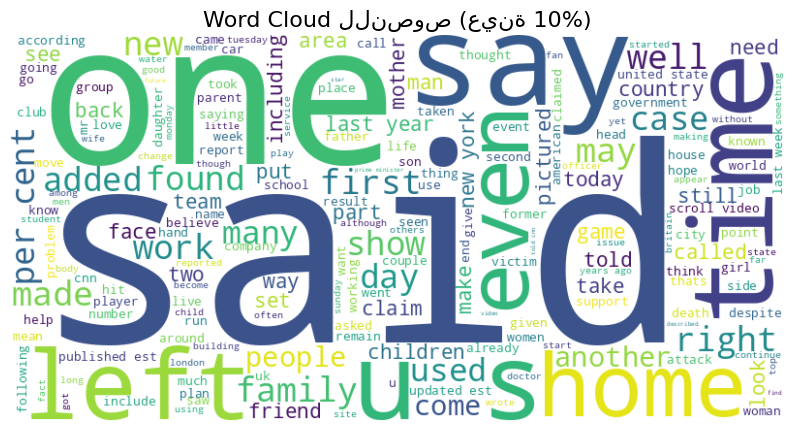

In [ ]:
import pandas as pd
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# قراءة ملف CSV
file_path = '/content/data/cleaned_train_data.csv'
df = pd.read_csv(file_path)

# التأكد من وجود العمود الذي يحتوي النصوص
text_column = 'article_cleaned'  # استبدل باسم العمود الذي يحتوي النصوص
if text_column not in df.columns:
    raise ValueError(f"العمود '{text_column}' غير موجود في الملف")

# أخذ عينة 10% من النصوص
sampled_text = df[text_column].sample(frac=0.1, random_state=42)  # عينة 10% من النصوص

# دمج النصوص في السلسلة واحدة
all_text = ' '.join(sampled_text.dropna().astype(str))

# إنشاء مخطط Word Cloud مع تحديد 200 كلمة كحد أقصى
wordcloud = WordCloud(width=800, height=400, background_color='white', max_words=200).generate(all_text)

# عرض الرسم
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')  # إخفاء المحاور
plt.title("Word Cloud للنصوص (عينة 10%)", fontsize=16)
plt.show()


تقسيم الى فقرات والحصول على الجملة الاولى والاخيرة على مستوى نص واحد

In [ ]:
import pandas as pd
from nltk.tokenize import sent_tokenize

# قراءة ملف CSV
file_path = '/content/data/cleaned_train_data.csv'
df = pd.read_csv(file_path)

# دالة لتقسيم النص إلى فقرات
def split_into_paragraphs(text):
    paragraphs = text.split("\n\n")  # تقسيم النص إلى فقرات باستخدام الفاصل \n\n
    return [p.strip() for p in paragraphs if p.strip()]  # إزالة المسافات الزائدة

# دالة لاستخراج أول وآخر جملة من النص
def get_first_and_last_sentence(paragraph):
    sentences = sent_tokenize(paragraph)  # تقسيم الفقرة إلى جمل
    if len(sentences) > 0:
        first_sentence = sentences[0]  # الجملة الأولى
        last_sentence = sentences[-1]  # الجملة الأخيرة
        return first_sentence, last_sentence
    return "", ""  # إذا كانت الفقرة فارغة

# أخذ عينة عشوائية من النص
sample_text = df['article_cleaned'].sample(n=1).iloc[0]

# تقسيم المقالة إلى فقرات
paragraphs = split_into_paragraphs(sample_text)

# طباعة الفقرات مع أول وآخر جملة
for idx, paragraph in enumerate(paragraphs, 1):
    first_sentence, last_sentence = get_first_and_last_sentence(paragraph)
    print(f"فقرة {idx}:\n{paragraph}\n")
    print(f"أول جملة: {first_sentence}")
    print(f"آخر جملة: {last_sentence}\n")


فقرة 1:
british woman travelled syria young son escaping isis stronghold begged father take home describing life jihadists hard. tareena shakil, 25, ran away wartorn country last october telling relatives going holiday spain 17monthold son zaheem. however, towie fan said life isisheld city raqqa hard escaped back across turkish border after, claims, militants tried force marrying onelegged fighter. shakil, burtonontrent, staffordshire, asked father forgiveness begged please take home, told could potentially sent back syria clutches terrorist group. scroll video . tareena shakil, 25, left fled syria join isis toddler son zaheem together right changing mind escaping turkey, begged father free detention centre . shakil fled back across turkish border 17monthold son zaheem isis tried force marriage, claims. fled syria secret november telling family going holiday . mother son currently held turkish detention centre, pair met shakils father emotional twohour reunion yesterday. according sun,

الحصول على اول جملة واخر جملة مطبقة على كل الداتا

> Add blockquote




In [ ]:
import pandas as pd
from nltk.tokenize import sent_tokenize

# قراءة ملف CSV
file_path = '/content/data/cleaned_train_data.csv'
df = pd.read_csv(file_path)

# دالة لتقسيم النص إلى فقرات
def split_into_paragraphs(text):
    paragraphs = text.split("\n\n")  # تقسيم النص إلى فقرات باستخدام الفاصل \n\n
    return [p.strip() for p in paragraphs if p.strip()]  # إزالة المسافات الزائدة

# دالة لاستخراج أول وآخر جملة من النص
def get_first_and_last_sentence(paragraph):
    sentences = sent_tokenize(paragraph)  # تقسيم الفقرة إلى جمل
    if len(sentences) > 0:
        first_sentence = sentences[0]  # الجملة الأولى
        last_sentence = sentences[-1]  # الجملة الأخيرة
        return first_sentence, last_sentence
    return "", ""  # إذا كانت الفقرة فارغة

# قائمة لتخزين النتائج
results = []

# تطبيق الكود على جميع النصوص في ملف CSV
for idx, row in df.iterrows():
    sample_text = row['article_cleaned']  # المقالة من العمود article_cleaned
    paragraphs = split_into_paragraphs(sample_text)  # تقسيم المقالة إلى فقرات

    # استخراج أول وآخر جملة من كل فقرة
    for paragraph in paragraphs:
        first_sentence, last_sentence = get_first_and_last_sentence(paragraph)
        results.append({
            'فقرة': paragraph,
            'أول جملة': first_sentence,
            'آخر جملة': last_sentence
        })

# تحويل النتائج إلى DataFrame
results_df = pd.DataFrame(results)

# طباعة أول 5 عينات
print(results_df.head(5))


                                                فقرة  \
0  . associated press . published . 1411 est, 25 ...   
1  cnn ralph mata internal affairs lieutenant mia...   
2  drunk driver killed young woman headon crash c...   
3  cnn breezy sweep pen president vladimir putin ...   
4  fleetwood team still 100 record sky bet league...   

                                            أول جملة  \
0                                                  .   
1  cnn ralph mata internal affairs lieutenant mia...   
2  drunk driver killed young woman headon crash c...   
3  cnn breezy sweep pen president vladimir putin ...   
4  fleetwood team still 100 record sky bet league...   

                                            آخر جملة  
0  fargo catholic diocese north dakota pictured b...  
1            cnns suzanne presto contributed report.  
2  ecclestontodd, newport, isle wight, also disqu...  
3  one afford cut lifeline, especially europes ec...  
4  danny kedwell kortney hause twice gave gills l..

حساب الجمل ذات الوزن الاعلى بناء على TF-IDF

In [ ]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.tokenize import sent_tokenize

# قراءة ملف CSV
file_path = '/content/data/cleaned_train_data.csv'
df = pd.read_csv(file_path)

# استخراج النصوص من العمود المطلوب
text_column = 'article_cleaned'  # استبدل باسم العمود الذي يحتوي النصوص
texts = df[text_column].dropna().astype(str)  # إزالة النصوص الفارغة والتأكد من أن جميع النصوص هي نصوص

# دالة لحساب الجمل ذات الوزن الأعلى باستخدام TF-IDF
def get_top_sentences(text, top_n=5):
    # تقسيم النص إلى جمل
    sentences = sent_tokenize(text)

    # إذا كان النص يحتوي على أقل من عدد الجمل المطلوبة
    if len(sentences) < top_n:
        return sentences

    # حساب قيم TF-IDF
    vectorizer = TfidfVectorizer()
    tfidf_matrix = vectorizer.fit_transform(sentences)
    tfidf_scores = tfidf_matrix.sum(axis=1).A1  # مجموع القيم لكل جملة

    # ترتيب الجمل بناءً على الوزن
    sorted_indices = tfidf_scores.argsort()[::-1]  # ترتيب تنازلي
    top_sentences = [sentences[i] for i in sorted_indices[:top_n]]
    return top_sentences

# تطبيق الدالة على النصوص واستخراج النتائج
top_sentences_per_text = []

for text in texts:
    top_sentences = get_top_sentences(text, top_n=5)
    top_sentences_per_text.append(top_sentences)

# عرض النتائج لأول 5 مقالات
for idx, sentences in enumerate(top_sentences_per_text[:5], 1):
    print(f"النص {idx}:\n")
    for i, sentence in enumerate(sentences, 1):
        print(f"الجملة {i}: {sentence}")
    print("\n" + "="*50 + "\n")


KeyboardInterrupt: 

الجمل ذات الوزن الاعلى التي تحوى على اسماء اشارة

In [ ]:
import pandas as pd
from nltk.tokenize import sent_tokenize
##تجربة اولى باستخدام مكتبة
# قائمة عبارات الإشارة بالإنجليزية
signal_phrases =  [
    "in conclusion", "to summarize", "in summary", "overall", "in short", "to sum up", "in brief",
    "furthermore", "moreover", "additionally", "in addition", "also", "besides", "not only",
    "however", "on the other hand", "nevertheless", "in contrast", "conversely", "although", "despite",
    "therefore", "as a result", "consequently", "thus", "hence", "because of this", "due to",
    "for example", "for instance", "such as", "to illustrate", "as an illustration", "namely", "in particular",
    "indeed", "in fact", "certainly", "of course", "undoubtedly", "clearly", "obviously",
    "first", "second", "finally", "next", "then", "after that", "subsequently",
    "that is", "in other words", "to put it differently", "this means that", "which means", "namely", "specifically",
    "as a result", "accordingly", "hence", "thus", "therefore", "so", "for this reason",
    "similarly", "likewise", "in the same way", "just as", "compared to", "in comparison", "equally"
]

# دالة لحساب وزن الجملة بناءً على عبارات الإشارة
def calculate_sentence_weight(sentence, signal_phrases):
    weight = 0
    for phrase in signal_phrases:
        if phrase.lower() in sentence.lower():  # البحث عن العبارات بغض النظر عن حالة الأحرف
            weight += 1
    return weight

# دالة لاستخراج الجمل ذات الوزن الأعلى
def get_top_signal_sentences(text, signal_phrases, top_n=5):
    sentences = sent_tokenize(text)  # تقسيم النص إلى جمل
    sentence_weights = [
        (sentence, calculate_sentence_weight(sentence, signal_phrases))
        for sentence in sentences
    ]
    # ترتيب الجمل حسب الوزن تنازليًا
    sorted_sentences = sorted(sentence_weights, key=lambda x: x[1], reverse=True)
    # استخراج الجمل ذات الوزن الأعلى
    top_sentences = [s[0] for s in sorted_sentences[:top_n]]
    return top_sentences

# قراءة ملف CSV
file_path = '/content/data/cleaned_train_data.csv'  # استبدل بمسار ملفك
df = pd.read_csv(file_path)

# استخراج النصوص من العمود المطلوب
text_column = 'article_cleaned'  # استبدل باسم العمود الذي يحتوي النصوص
texts = df[text_column].dropna().astype(str)  # إزالة النصوص الفارغة والتأكد من أن جميع النصوص هي نصوص

# استخراج الجمل ذات الوزن الأعلى لكل نص
top_sentences_per_text = []

for text in texts:
    top_sentences = get_top_signal_sentences(text, signal_phrases, top_n=5)
    top_sentences_per_text.append(top_sentences)

# عرض النتائج لأول 5 نصوص
for idx, sentences in enumerate(top_sentences_per_text[:5], 1):
    print(f"Text {idx}:\n")
    for i, sentence in enumerate(sentences, 1):
        print(f"Sentence {i}: {sentence}")
    print("\n" + "="*50 + "\n")


النتيجة غير مرضية لأن النقطة تظهر لوحدها على انها جملة سيتم الاختبار بطريقة اخرى

تجربة 2
اختيار الجمل الي طولها 4 واكثر

In [ ]:
import pandas as pd
from nltk.tokenize import sent_tokenize, word_tokenize

# قائمة عبارات الإشارة بالإنجليزية
signal_phrases = [
    "in conclusion", "to summarize", "in summary", "overall", "in short", "to sum up", "in brief",
    "furthermore", "moreover", "additionally", "in addition", "also", "besides", "not only",
    "however", "on the other hand", "nevertheless", "in contrast", "conversely", "although", "despite",
    "therefore", "as a result", "consequently", "thus", "hence", "because of this", "due to",
    "for example", "for instance", "such as", "to illustrate", "as an illustration", "namely", "in particular",
    "indeed", "in fact", "certainly", "of course", "undoubtedly", "clearly", "obviously",
    "first", "second", "finally", "next", "then", "after that", "subsequently",
    "that is", "in other words", "to put it differently", "this means that", "which means", "namely", "specifically",
    "as a result", "accordingly", "hence", "thus", "therefore", "so", "for this reason",
    "similarly", "likewise", "in the same way", "just as", "compared to", "in comparison", "equally"
]

# دالة لحساب وزن الجملة بناءً على عبارات الإشارة
def calculate_sentence_weight(sentence, signal_phrases):
    words = word_tokenize(sentence)  # تقسيم الجملة إلى كلمات
    if len(words) < 4:  # شرط أن تحتوي الجملة على أربع كلمات على الأقل
        return 0
    weight = 0
    for phrase in signal_phrases:
        if phrase.lower() in sentence.lower():  # البحث عن العبارات بغض النظر عن حالة الأحرف
            weight += 1
    return weight

# دالة لاستخراج الجمل ذات الوزن الأعلى
def get_top_signal_sentences(text, signal_phrases, top_n=5):
    sentences = sent_tokenize(text)  # تقسيم النص إلى جمل
    sentence_weights = [
        (sentence, calculate_sentence_weight(sentence, signal_phrases))
        for sentence in sentences
    ]
    # ترتيب الجمل حسب الوزن تنازليًا
    sorted_sentences = sorted(sentence_weights, key=lambda x: x[1], reverse=True)
    # استخراج الجمل ذات الوزن الأعلى
    top_sentences = [s[0] for s in sorted_sentences[:top_n]]
    return top_sentences

# قراءة ملف CSV
file_path = '/content/data/cleaned_train_data.csv'  # استبدل بمسار ملفك
df = pd.read_csv(file_path)

# استخراج النصوص من العمود المطلوب
text_column = 'article_cleaned'  # استبدل باسم العمود الذي يحتوي النصوص
texts = df[text_column].dropna().astype(str)  # إزالة النصوص الفارغة والتأكد من أن جميع النصوص هي نصوص

# استخراج الجمل ذات الوزن الأعلى لكل نص
top_sentences_per_text = []

for text in texts:
    top_sentences = get_top_signal_sentences(text, signal_phrases, top_n=5)
    top_sentences_per_text.append(top_sentences)

# عرض النتائج لأول 5 نصوص
for idx, sentences in enumerate(top_sentences_per_text[:5], 1):
    print(f"Text {idx}:\n")
    for i, sentence in enumerate(sentences, 1):
        print(f"Sentence {i}: {sentence}")
    print("\n" + "="*50 + "\n")


التجربة المعتمدة
الجملة 4 كلمات واطول
التقسيم باستخدام تعبير منتظم

In [ ]:
import re
import pandas as pd
from nltk.tokenize import sent_tokenize

# قائمة عبارات الإشارة بالإنجليزية
signal_phrases = [
    "in conclusion", "to summarize", "in summary", "overall", "in short", "to sum up", "in brief",
    "furthermore", "moreover", "additionally", "in addition", "also", "besides", "not only",
    "however", "on the other hand", "nevertheless", "in contrast", "conversely", "although", "despite",
    "therefore", "as a result", "consequently", "thus", "hence", "because of this", "due to",
    "for example", "for instance", "such as", "to illustrate", "as an illustration", "namely", "in particular",
    "indeed", "in fact", "certainly", "of course", "undoubtedly", "clearly", "obviously",
    "first", "second", "finally", "next", "then", "after that", "subsequently",
    "that is", "in other words", "to put it differently", "this means that", "which means", "namely", "specifically",
    "as a result", "accordingly", "hence", "thus", "therefore", "so", "for this reason",
    "similarly", "likewise", "in the same way", "just as", "compared to", "in comparison", "equally"
]

# دالة لحساب وزن الجملة بناءً على عبارات الإشارة
def calculate_sentence_weight(sentence, signal_phrases):
    # استخدام التعبير المنتظم لتقسيم الجملة إلى كلمات
    words = re.findall(r'\w+', sentence)
    if len(words) < 4:  # شرط أن تحتوي الجملة على أربع كلمات على الأقل
        return 0
    weight = 0
    for phrase in signal_phrases:
        if phrase.lower() in sentence.lower():  # البحث عن العبارات بغض النظر عن حالة الأحرف
            weight += 1
    return weight

# دالة لاستخراج الجمل ذات الوزن الأعلى
def get_top_signal_sentences(text, signal_phrases, top_n=5):
    sentences = sent_tokenize(text)  # تقسيم النص إلى جمل
    sentence_weights = [
        (sentence, calculate_sentence_weight(sentence, signal_phrases))
        for sentence in sentences
        if re.search(r'\w+', sentence)  # تجاهل الجمل التي لا تحتوي على كلمات (مثل "." فقط)
    ]
    # ترتيب الجمل حسب الوزن تنازليًا
    sorted_sentences = sorted(sentence_weights, key=lambda x: x[1], reverse=True)
    # استخراج الجمل ذات الوزن الأعلى
    top_sentences = [s[0] for s in sorted_sentences[:top_n]]
    return top_sentences

# قراءة ملف CSV
file_path = '/content/data/cleaned_train_data.csv'  # استبدل بمسار ملفك
df = pd.read_csv(file_path)

# استخراج النصوص من العمود المطلوب
text_column = 'article_cleaned'  # استبدل باسم العمود الذي يحتوي النصوص
texts = df[text_column].dropna().astype(str)  # إزالة النصوص الفارغة والتأكد من أن جميع النصوص هي نصوص

# استخراج الجمل ذات الوزن الأعلى لكل نص
top_sentences_per_text = []

for text in texts:
    top_sentences = get_top_signal_sentences(text, signal_phrases, top_n=5)
    top_sentences_per_text.append(top_sentences)

# عرض النتائج لأول 5 نصوص
for idx, sentences in enumerate(top_sentences_per_text[:5], 1):
    print(f"Text {idx}:\n")
    for i, sentence in enumerate(sentences, 1):
        print(f"Sentence {i}: {sentence}")
    print("\n" + "="*50 + "\n")


# **Baseline model**

In [ ]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.pipeline import make_pipeline
from nltk.tokenize import sent_tokenize

# روابط الملفات
train_file_path = '/content/data/cleaned_train_data.csv'       # ملف التدريب
validation_file_path = '/content/data/cleaned_validation_data.csv'  # ملف الفاليديشن
test_file_path = '/content/data/cleaned_test_data.csv'         # ملف الاختبار

# قراءة البيانات
df_train = pd.read_csv(train_file_path)
df_validation = pd.read_csv(validation_file_path)
df_test = pd.read_csv(test_file_path)

# التأكد من أن الأعمدة تحتوي على المقالات والملخصات
article_column = 'article_cleaned'  # اسم العمود الذي يحتوي على المقالات
summary_column = 'summary_cleaned'  # اسم العمود الذي يحتوي على الملخصات

# دالة لتقسيم المقال إلى جمل
def split_into_sentences(text):
    return sent_tokenize(text)

# معالجة بيانات التدريب
df_train['sentences'] = df_train[article_column].apply(split_into_sentences)
sentences_train = []
labels_train = []
for _, row in df_train.iterrows():
    for sentence in row['sentences']:
        sentences_train.append(sentence)
        if sentence in row[summary_column]:
            labels_train.append(1)  # جملة مهمة
        else:
            labels_train.append(0)  # جملة غير مهمة

# معالجة بيانات الفاليديشن
df_validation['sentences'] = df_validation[article_column].apply(split_into_sentences)
sentences_validation = []
labels_validation = []
for _, row in df_validation.iterrows():
    for sentence in row['sentences']:
        sentences_validation.append(sentence)
        if sentence in row[summary_column]:
            labels_validation.append(1)  # جملة مهمة
        else:
            labels_validation.append(0)  # جملة غير مهمة

# بناء نموذج TF-IDF + Logistic Regression
model = make_pipeline(TfidfVectorizer(), LogisticRegression(max_iter=1000, random_state=42))

# تدريب النموذج على بيانات التدريب
model.fit(sentences_train, labels_train)

# تقييم النموذج على بيانات الفاليديشن
y_pred_validation = model.predict(sentences_validation)
print("Classification Report (Validation Data):")
print(classification_report(labels_validation, y_pred_validation))

# معالجة بيانات الاختبار
df_test['sentences'] = df_test[article_column].apply(split_into_sentences)
sentences_test = []
labels_test = []
for _, row in df_test.iterrows():
    for sentence in row['sentences']:
        sentences_test.append(sentence)
        if sentence in row[summary_column]:
            labels_test.append(1)  # جملة مهمة
        else:
            labels_test.append(0)  # جملة غير مهمة

# التقييم النهائي على بيانات الاختبار
y_pred_test = model.predict(sentences_test)
print("Classification Report (Test Data):")
print(classification_report(labels_test, y_pred_test))

# دالة لاستخراج الجمل المهمة بناءً على التنبؤات
def extract_important_sentences(article, model, top_n=5):
    sentences = split_into_sentences(article)
    sentence_weights = [
        (sentence, model.predict([sentence])[0])  # التنبؤ إذا كانت الجملة مهمة أو غير مهمة
        for sentence in sentences
    ]
    # ترتيب الجمل بحسب التنبؤات
    sorted_sentences = sorted(sentence_weights, key=lambda x: x[1], reverse=True)
    important_sentences = [s[0] for s in sorted_sentences[:top_n]]  # استخراج الجمل المهمة
    return important_sentences

# اختبار على 5 مقالات من ملف التيست
for i in range(5):
    article = df_test.iloc[i][article_column]
    important_sentences = extract_important_sentences(article, model)
    print(f"\nArticle {i+1} - Important Sentences:")
    for j, sentence in enumerate(important_sentences, 1):
        print(f"{j}. {sentence}")

Classification Report (Validation Data):
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    420096
           1       0.59      0.03      0.06       693

    accuracy                           1.00    420789
   macro avg       0.79      0.52      0.53    420789
weighted avg       1.00      1.00      1.00    420789

Classification Report (Test Data):
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    366285
           1       0.39      0.01      0.03       532

    accuracy                           1.00    366817
   macro avg       0.69      0.51      0.51    366817
weighted avg       1.00      1.00      1.00    366817


Article 1 - Important Sentences:
1. ever noticed plane seats appear getting smaller smaller increasing numbers people taking skies, experts questioning packed planes putting passengers risk.
2. say shrinking space aeroplanes uncomfortable putting health safety danger.


In [ ]:
from rouge_score import rouge_scorer

# دالة لحساب تقييم ROUGE
def calculate_rouge_scores(references, candidates):
    scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)
    scores = {'rouge1': [], 'rouge2': [], 'rougeL': []}
    for ref, cand in zip(references, candidates):
        score = scorer.score(ref, cand)
        scores['rouge1'].append(score['rouge1'].fmeasure)
        scores['rouge2'].append(score['rouge2'].fmeasure)
        scores['rougeL'].append(score['rougeL'].fmeasure)
    # حساب المتوسط لكل نوع
    avg_scores = {key: sum(values) / len(values) for key, values in scores.items()}
    return avg_scores

# استخراج الجمل المهمة من المقالات واختبارها باستخدام ROUGE
references = []
candidates = []
for i in range(len(df_test)):
    article = df_test.iloc[i][article_column]
    summary = df_test.iloc[i][summary_column]
    # استخراج الجمل المهمة باستخدام النموذج
    important_sentences = extract_important_sentences(article, model, top_n=5)
    # تحويل الجمل المستخرجة والمرجعية إلى نصوص
    candidate_summary = " ".join(important_sentences)
    references.append(summary)
    candidates.append(candidate_summary)

# حساب تقييم ROUGE
rouge_scores = calculate_rouge_scores(references, candidates)

# طباعة النتائج
print("\nROUGE Scores:")
for metric, score in rouge_scores.items():
    print(f"{metric}: {score:.4f}")


ROUGE Scores:
rouge1: 0.3470
rouge2: 0.1604
rougeL: 0.2422


# RandomForest with other features

# اضافة الاوزان من اجل كل ميزة

In [ ]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from nltk.tokenize import sent_tokenize, word_tokenize
from sklearn.preprocessing import StandardScaler
from rouge_score import rouge_scorer

# 1. قراءة البيانات
train_file_path = '/content/data/cleaned_train_data.csv'
val_file_path = '/content/data/cleaned_validation_data.csv'
test_file_path = '/content/data/cleaned_test_data.csv'

df_train = pd.read_csv(train_file_path)
df_val = pd.read_csv(val_file_path)
df_test = pd.read_csv(test_file_path)

article_column = 'article_cleaned'  # اسم العمود الذي يحتوي على المقالات
summary_column = 'summary_cleaned'  # اسم العمود الذي يحتوي على الملخصات المرجعية

# 2. تعريف الأوزان المبدئية للميزات
weights = {
    "tfidf_score": 0.2,  # أهمية TF-IDF
    "is_first": 0.2,     # الجملة الأولى
    "is_last": 0.2,      # الجملة الأخيرة
    "length": 0.2,       # طول الجملة
    "signal_weight": 0.2 # عبارات الإشارة
}

# 3. تعريف دوال الميزات
def calculate_tfidf_scores(sentences, vectorizer=None):
    if vectorizer is None:
        vectorizer = TfidfVectorizer()
        vectorizer.fit(sentences)
    tfidf_matrix = vectorizer.transform(sentences)
    tfidf_scores = tfidf_matrix.sum(axis=1).A1  # مجموع القيم لكل جملة
    return tfidf_scores, vectorizer

def calculate_signal_weight(sentence, signal_phrases):
    weight = sum(phrase.lower() in sentence.lower() for phrase in signal_phrases)
    return weight

def calculate_sentence_score(features, weights):
    score = (
        weights["tfidf_score"] * features[0] +
        weights["is_first"] * features[1] +
        weights["is_last"] * features[2] +
        weights["length"] * features[3] +
        weights["signal_weight"] * features[4]
    )
    return score

def extract_features(article, summary, vectorizer=None, signal_phrases=[]):
    sentences = sent_tokenize(article)
    tfidf_scores, vectorizer = calculate_tfidf_scores(sentences, vectorizer)

    features = []
    labels = []
    sentence_scores = []

    # حساب طول الجملة (عدد الكلمات)
    sentence_lengths = [len(word_tokenize(sentence)) for sentence in sentences]

    for i, sentence in enumerate(sentences):
        tfidf_score = tfidf_scores[i]
        is_first = int(i == 0)
        is_last = int(i == len(sentences) - 1)
        length = sentence_lengths[i]
        signal_weight = calculate_signal_weight(sentence, signal_phrases)
        is_important = int(sentence in summary)

        feature_vector = [tfidf_score, is_first, is_last, length, signal_weight]
        features.append(feature_vector)
        labels.append(is_important)

        # حساب درجة الجملة باستخدام الأوزان
        score = calculate_sentence_score(feature_vector, weights)
        sentence_scores.append(score)

    return np.array(features), np.array(labels), vectorizer, sentence_scores, sentence_lengths

# قائمة عبارات الإشارة
signal_phrases = [
    "in conclusion", "to summarize", "in summary", "in short", "to sum up", "in brief",
    "furthermore", "moreover", "additionally", "in addition", "also", "besides", "not only",
    "however", "on the other hand", "nevertheless", "in contrast", "conversely", "although", "despite",
    "therefore", "as a result", "consequently", "thus", "hence", "because of this", "due to",
    "for example", "for instance", "such as", "to illustrate", "as an illustration", "namely", "in particular",
    "indeed", "in fact", "certainly", "of course", "undoubtedly", "clearly", "obviously",
    "first", "second", "finally", "next", "then", "after that", "subsequently",
    "that is", "in other words", "to put it differently", "this means that", "which means", "namely", "specifically",
    "as a result", "accordingly", "hence", "thus", "therefore", "so", "for this reason",
    "similarly", "likewise", "in the same way", "just as", "compared to", "in comparison", "equally"
]

# 4. استخراج الميزات من بيانات التدريب
X_train, y_train, tfidf_vectorizer, train_scores, train_sentence_lengths = [], [], None, [], []
for _, row in df_train.iterrows():
    features, labels, tfidf_vectorizer, scores, sentence_lengths = extract_features(
        row[article_column], row[summary_column], tfidf_vectorizer, signal_phrases
    )
    X_train.extend(features)
    y_train.extend(labels)
    train_scores.extend(scores)
    train_sentence_lengths.extend(sentence_lengths)

X_train = np.array(X_train)
y_train = np.array(y_train)

# 5. استخراج الميزات من بيانات التحقق
X_val, y_val, val_scores, val_sentence_lengths = [], [], [], []
for _, row in df_val.iterrows():
    features, labels, _, scores, sentence_lengths = extract_features(
        row[article_column], row[summary_column], tfidf_vectorizer, signal_phrases
    )
    X_val.extend(features)
    y_val.extend(labels)
    val_scores.extend(scores)
    val_sentence_lengths.extend(sentence_lengths)

X_val = np.array(X_val)
y_val = np.array(y_val)

# 6. تدريب النموذج
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)

model = RandomForestClassifier(random_state=42)
model.fit(X_train_scaled, y_train)

# 7. تقييم النموذج
y_val_pred = model.predict(X_val_scaled)
print("Validation Classification Report:")
print(classification_report(y_val, y_val_pred))

# 8. توليد ملخص مع الأوزان
def generate_summary(article, model, scaler, tfidf_vectorizer, signal_phrases, weights, top_n=5):
    sentences = sent_tokenize(article)
    tfidf_scores, _ = calculate_tfidf_scores(sentences, tfidf_vectorizer)

    sentence_scores = []
    for i, sentence in enumerate(sentences):
        tfidf_score = tfidf_scores[i]
        is_first = int(i == 0)
        is_last = int(i == len(sentences) - 1)
        length = len(word_tokenize(sentence))
        signal_weight = calculate_signal_weight(sentence, signal_phrases)

        features = [tfidf_score, is_first, is_last, length, signal_weight]
        score = calculate_sentence_score(features, weights)
        sentence_scores.append((sentence, score, length))

    important_sentences = sorted(sentence_scores, key=lambda x: (x[1], x[2]), reverse=True)[:top_n]
    return [s[0] for s in important_sentences]
# 8. حساب ROUGE
def calculate_rouge_scores(reference, generated):
    scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)
    scores = scorer.score(reference, generated)
    return scores

# تقييم النموذج باستخدام بيانات الاختبار
rouge1_scores = []
rouge2_scores = []
rougeL_scores = []

for i in range(len(df_test)):
    article = df_test.iloc[i][article_column]
    reference_summary = df_test.iloc[i][summary_column]

    # إنتاج الملخص باستخدام النموذج
    generated_summary = " ".join(generate_summary(article, model, scaler, tfidf_vectorizer, signal_phrases, weights))

    # حساب ROUGE
    scores = calculate_rouge_scores(reference_summary, generated_summary)

    rouge1_scores.append(scores['rouge1'].fmeasure)
    rouge2_scores.append(scores['rouge2'].fmeasure)
    rougeL_scores.append(scores['rougeL'].fmeasure)

# حساب متوسط القيم
avg_rouge1 = np.mean(rouge1_scores)
avg_rouge2 = np.mean(rouge2_scores)
avg_rougeL = np.mean(rougeL_scores)

print("Average ROUGE Scores:")
print(f"ROUGE-1: {avg_rouge1:.4f}")
print(f"ROUGE-2: {avg_rouge2:.4f}")
print(f"ROUGE-L: {avg_rougeL:.4f}")


Validation Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    420096
           1       0.95      0.26      0.41       693

    accuracy                           1.00    420789
   macro avg       0.98      0.63      0.70    420789
weighted avg       1.00      1.00      1.00    420789


Average ROUGE Scores:
ROUGE-1: 0.2471
ROUGE-2: 0.0977
ROUGE-L: 0.1561


تجربة مع تغيير الاوزان

In [ ]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from nltk.tokenize import sent_tokenize, word_tokenize
from sklearn.preprocessing import StandardScaler
from rouge_score import rouge_scorer

# 1. قراءة البيانات
train_file_path = '/content/data/cleaned_train_data.csv'
val_file_path = '/content/data/cleaned_validation_data.csv'
test_file_path = '/content/data/cleaned_test_data.csv'

df_train = pd.read_csv(train_file_path)
df_val = pd.read_csv(val_file_path)
df_test = pd.read_csv(test_file_path)

article_column = 'article_cleaned'  # اسم العمود الذي يحتوي على المقالات
summary_column = 'summary_cleaned'  # اسم العمود الذي يحتوي على الملخصات المرجعية

# 2. تعريف الأوزان المبدئية للميزات
# 2. تعريف الأوزان المبدئية للميزات
weights = {
    "tfidf_score": 0.2,  # أهمية TF-IDF
    "is_first": 0.2,     # الجملة الأولى
    "is_last": 0.2,      # الجملة الأخيرة
    "length": 0.1,       # طول الجملة
    "signal_weight": 0.3 # عبارات الإشارة
}

# 3. تعريف دوال الميزات
def calculate_tfidf_scores(sentences, vectorizer=None):
    if vectorizer is None:
        vectorizer = TfidfVectorizer()
        vectorizer.fit(sentences)
    tfidf_matrix = vectorizer.transform(sentences)
    tfidf_scores = tfidf_matrix.sum(axis=1).A1  # مجموع القيم لكل جملة
    return tfidf_scores, vectorizer

def calculate_signal_weight(sentence, signal_phrases):
    weight = sum(phrase.lower() in sentence.lower() for phrase in signal_phrases)
    return weight

def calculate_sentence_score(features, weights):
    score = (
        weights["tfidf_score"] * features[0] +
        weights["is_first"] * features[1] +
        weights["is_last"] * features[2] +
        weights["length"] * features[3] +
        weights["signal_weight"] * features[4]
    )
    return score

def extract_features(article, summary, vectorizer=None, signal_phrases=[]):
    sentences = sent_tokenize(article)
    tfidf_scores, vectorizer = calculate_tfidf_scores(sentences, vectorizer)

    features = []
    labels = []
    sentence_scores = []

    # حساب طول الجملة (عدد الكلمات)
    sentence_lengths = [len(word_tokenize(sentence)) for sentence in sentences]

    for i, sentence in enumerate(sentences):
        tfidf_score = tfidf_scores[i]
        is_first = int(i == 0)
        is_last = int(i == len(sentences) - 1)
        length = sentence_lengths[i]
        signal_weight = calculate_signal_weight(sentence, signal_phrases)
        is_important = int(sentence in summary)

        feature_vector = [tfidf_score, is_first, is_last, length, signal_weight]
        features.append(feature_vector)
        labels.append(is_important)

        # حساب درجة الجملة باستخدام الأوزان
        score = calculate_sentence_score(feature_vector, weights)
        sentence_scores.append(score)

    return np.array(features), np.array(labels), vectorizer, sentence_scores, sentence_lengths

# قائمة عبارات الإشارة
signal_phrases = [
    "in conclusion", "to summarize", "in summary", "in short", "to sum up", "in brief",
    "furthermore", "moreover", "additionally", "in addition", "also", "besides", "not only",
    "however", "on the other hand", "nevertheless", "in contrast", "conversely", "although", "despite",
    "therefore", "as a result", "consequently", "thus", "hence", "because of this", "due to",
    "for example", "for instance", "such as", "to illustrate", "as an illustration", "namely", "in particular",
    "indeed", "in fact", "certainly", "of course", "undoubtedly", "clearly", "obviously",
    "first", "second", "finally", "next", "then", "after that", "subsequently",
    "that is", "in other words", "to put it differently", "this means that", "which means", "namely", "specifically",
    "as a result", "accordingly", "hence", "thus", "therefore", "so", "for this reason",
    "similarly", "likewise", "in the same way", "just as", "compared to", "in comparison", "equally"
]

# 4. استخراج الميزات من بيانات التدريب
X_train, y_train, tfidf_vectorizer, train_scores, train_sentence_lengths = [], [], None, [], []
for _, row in df_train.iterrows():
    features, labels, tfidf_vectorizer, scores, sentence_lengths = extract_features(
        row[article_column], row[summary_column], tfidf_vectorizer, signal_phrases
    )
    X_train.extend(features)
    y_train.extend(labels)
    train_scores.extend(scores)
    train_sentence_lengths.extend(sentence_lengths)

X_train = np.array(X_train)
y_train = np.array(y_train)

# 5. استخراج الميزات من بيانات التحقق
X_val, y_val, val_scores, val_sentence_lengths = [], [], [], []
for _, row in df_val.iterrows():
    features, labels, _, scores, sentence_lengths = extract_features(
        row[article_column], row[summary_column], tfidf_vectorizer, signal_phrases
    )
    X_val.extend(features)
    y_val.extend(labels)
    val_scores.extend(scores)
    val_sentence_lengths.extend(sentence_lengths)

X_val = np.array(X_val)
y_val = np.array(y_val)

# 6. تدريب النموذج
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)

model = RandomForestClassifier(random_state=42)
model.fit(X_train_scaled, y_train)

# 7. تقييم النموذج
y_val_pred = model.predict(X_val_scaled)
print("Validation Classification Report:")
print(classification_report(y_val, y_val_pred))

# 8. توليد ملخص مع الأوزان
def generate_summary(article, model, scaler, tfidf_vectorizer, signal_phrases, weights, top_n=5):
    sentences = sent_tokenize(article)
    tfidf_scores, _ = calculate_tfidf_scores(sentences, tfidf_vectorizer)

    sentence_scores = []
    for i, sentence in enumerate(sentences):
        tfidf_score = tfidf_scores[i]
        is_first = int(i == 0)
        is_last = int(i == len(sentences) - 1)
        length = len(word_tokenize(sentence))
        signal_weight = calculate_signal_weight(sentence, signal_phrases)

        features = [tfidf_score, is_first, is_last, length, signal_weight]
        score = calculate_sentence_score(features, weights)
        sentence_scores.append((sentence, score, length))

    important_sentences = sorted(sentence_scores, key=lambda x: (x[1], x[2]), reverse=True)[:top_n]
    return [s[0] for s in important_sentences]
# 8. حساب ROUGE
def calculate_rouge_scores(reference, generated):
    scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)
    scores = scorer.score(reference, generated)
    return scores

# تقييم النموذج باستخدام بيانات الاختبار
rouge1_scores = []
rouge2_scores = []
rougeL_scores = []

for i in range(len(df_test)):
    article = df_test.iloc[i][article_column]
    reference_summary = df_test.iloc[i][summary_column]

    # إنتاج الملخص باستخدام النموذج
    generated_summary = " ".join(generate_summary(article, model, scaler, tfidf_vectorizer, signal_phrases, weights))

    # حساب ROUGE
    scores = calculate_rouge_scores(reference_summary, generated_summary)

    rouge1_scores.append(scores['rouge1'].fmeasure)
    rouge2_scores.append(scores['rouge2'].fmeasure)
    rougeL_scores.append(scores['rougeL'].fmeasure)

# حساب متوسط القيم
avg_rouge1 = np.mean(rouge1_scores)
avg_rouge2 = np.mean(rouge2_scores)
avg_rougeL = np.mean(rougeL_scores)

print("\nAverage ROUGE Scores:")
print(f"ROUGE-1: {avg_rouge1:.4f}")
print(f"ROUGE-2: {avg_rouge2:.4f}")
print(f"ROUGE-L: {avg_rougeL:.4f}")


Validation Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    420096
           1       0.95      0.26      0.41       693

    accuracy                           1.00    420789
   macro avg       0.98      0.63      0.70    420789
weighted avg       1.00      1.00      1.00    420789


Average ROUGE Scores:
ROUGE-1: 0.2462
ROUGE-2: 0.0968
ROUGE-L: 0.1552


# Logistic Regression


In [ ]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from nltk.tokenize import sent_tokenize, word_tokenize
from sklearn.preprocessing import StandardScaler
from rouge_score import rouge_scorer
from sklearn.linear_model import LogisticRegression

# 1. قراءة البيانات
train_file_path = '/content/data/cleaned_train_data.csv'
val_file_path = '/content/data/cleaned_validation_data.csv'
test_file_path = '/content/data/cleaned_test_data.csv'

df_train = pd.read_csv(train_file_path)
df_val = pd.read_csv(val_file_path)
df_test = pd.read_csv(test_file_path)

article_column = 'article_cleaned'  # اسم العمود الذي يحتوي على المقالات
summary_column = 'summary_cleaned'  # اسم العمود الذي يحتوي على الملخصات المرجعية

# 2. تعريف الأوزان المبدئية للميزات
weights = {
    "tfidf_score": 0.2,  # أهمية TF-IDF
    "is_first": 0.2,     # الجملة الأولى
    "is_last": 0.2,      # الجملة الأخيرة
    "length": 0.1,       # طول الجملة
    "signal_weight": 0.3 # عبارات الإشارة
}

# 3. تعريف دوال الميزات
def calculate_tfidf_scores(sentences, vectorizer=None):
    if vectorizer is None:
        vectorizer = TfidfVectorizer()
        vectorizer.fit(sentences)
    tfidf_matrix = vectorizer.transform(sentences)
    tfidf_scores = tfidf_matrix.sum(axis=1).A1  # مجموع القيم لكل جملة
    return tfidf_scores, vectorizer

def calculate_signal_weight(sentence, signal_phrases):
    weight = sum(phrase.lower() in sentence.lower() for phrase in signal_phrases)
    return weight

def calculate_sentence_score(features, weights):
    score = (
        weights["tfidf_score"] * features[0] +
        weights["is_first"] * features[1] +
        weights["is_last"] * features[2] +
        weights["length"] * features[3] +
        weights["signal_weight"] * features[4]
    )
    return score

def extract_features(article, summary, vectorizer=None, signal_phrases=[]):
    sentences = sent_tokenize(article)
    tfidf_scores, vectorizer = calculate_tfidf_scores(sentences, vectorizer)

    features = []
    labels = []
    sentence_scores = []

    # حساب طول الجملة (عدد الكلمات)
    sentence_lengths = [len(word_tokenize(sentence)) for sentence in sentences]

    for i, sentence in enumerate(sentences):
        tfidf_score = tfidf_scores[i]
        is_first = int(i == 0)
        is_last = int(i == len(sentences) - 1)
        length = sentence_lengths[i]
        signal_weight = calculate_signal_weight(sentence, signal_phrases)
        is_important = int(sentence in summary)

        feature_vector = [tfidf_score, is_first, is_last, length, signal_weight]
        features.append(feature_vector)
        labels.append(is_important)

        # حساب درجة الجملة باستخدام الأوزان
        score = calculate_sentence_score(feature_vector, weights)
        sentence_scores.append(score)

    return np.array(features), np.array(labels), vectorizer, sentence_scores, sentence_lengths

# قائمة عبارات الإشارة
signal_phrases = [
    "in conclusion", "to summarize", "in summary", "in short", "to sum up", "in brief",
    "furthermore", "moreover", "additionally", "in addition", "also", "besides", "not only",
    "however", "on the other hand", "nevertheless", "in contrast", "conversely", "although", "despite",
    "therefore", "as a result", "consequently", "thus", "hence", "because of this", "due to",
    "for example", "for instance", "such as", "to illustrate", "as an illustration", "namely", "in particular",
    "indeed", "in fact", "certainly", "of course", "undoubtedly", "clearly", "obviously",
    "first", "second", "finally", "next", "then", "after that", "subsequently",
    "that is", "in other words", "to put it differently", "this means that", "which means", "namely", "specifically",
    "as a result", "accordingly", "hence", "thus", "therefore", "so", "for this reason",
    "similarly", "likewise", "in the same way", "just as", "compared to", "in comparison", "equally"
]

# 4. استخراج الميزات من بيانات التدريب
X_train, y_train, tfidf_vectorizer, train_scores, train_sentence_lengths = [], [], None, [], []
for _, row in df_train.iterrows():
    features, labels, tfidf_vectorizer, scores, sentence_lengths = extract_features(
        row[article_column], row[summary_column], tfidf_vectorizer, signal_phrases
    )
    X_train.extend(features)
    y_train.extend(labels)
    train_scores.extend(scores)
    train_sentence_lengths.extend(sentence_lengths)

X_train = np.array(X_train)
y_train = np.array(y_train)

# 5. استخراج الميزات من بيانات التحقق
X_val, y_val, val_scores, val_sentence_lengths = [], [], [], []
for _, row in df_val.iterrows():
    features, labels, _, scores, sentence_lengths = extract_features(
        row[article_column], row[summary_column], tfidf_vectorizer, signal_phrases
    )
    X_val.extend(features)
    y_val.extend(labels)
    val_scores.extend(scores)
    val_sentence_lengths.extend(sentence_lengths)

X_val = np.array(X_val)
y_val = np.array(y_val)

# 6. تدريب النموذج
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)

# استبدال SVC بـ LogisticRegression
model = LogisticRegression(class_weight='balanced', random_state=42, max_iter=1000)
model.fit(X_train_scaled, y_train)

# 7. تقييم النموذج
y_val_pred = model.predict(X_val_scaled)
print("Validation Classification Report:")
print(classification_report(y_val, y_val_pred))

# 8. توليد ملخص مع الأوزان
def generate_summary(article, model, scaler, tfidf_vectorizer, signal_phrases, weights, top_n=5):
    sentences = sent_tokenize(article)
    tfidf_scores, _ = calculate_tfidf_scores(sentences, tfidf_vectorizer)

    sentence_scores = []
    for i, sentence in enumerate(sentences):
        tfidf_score = tfidf_scores[i]
        is_first = int(i == 0)
        is_last = int(i == len(sentences) - 1)
        length = len(word_tokenize(sentence))
        signal_weight = calculate_signal_weight(sentence, signal_phrases)

        features = [tfidf_score, is_first, is_last, length, signal_weight]
        score = calculate_sentence_score(features, weights)
        sentence_scores.append((sentence, score, length))

    important_sentences = sorted(sentence_scores, key=lambda x: (x[1], x[2]), reverse=True)[:top_n]
    return [s[0] for s in important_sentences]

# 9. حساب ROUGE
def calculate_rouge_scores(reference, generated):
    scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)
    scores = scorer.score(reference, generated)
    return scores

# تقييم النموذج باستخدام بيانات الاختبار
rouge1_scores = []
rouge2_scores = []
rougeL_scores = []

for i in range(len(df_test)):
    article = df_test.iloc[i][article_column]
    reference_summary = df_test.iloc[i][summary_column]

    # إنتاج الملخص باستخدام النموذج
    generated_summary = " ".join(generate_summary(article, model, scaler, tfidf_vectorizer, signal_phrases, weights))

    # حساب ROUGE
    scores = calculate_rouge_scores(reference_summary, generated_summary)

    rouge1_scores.append(scores['rouge1'].fmeasure)
    rouge2_scores.append(scores['rouge2'].fmeasure)
    rougeL_scores.append(scores['rougeL'].fmeasure)

# حساب متوسط القيم
avg_rouge1 = np.mean(rouge1_scores)
avg_rouge2 = np.mean(rouge2_scores)
avg_rougeL = np.mean(rougeL_scores)

print("\nAverage ROUGE Scores:")
print(f"ROUGE-1: {avg_rouge1:.4f}")
print(f"ROUGE-2: {avg_rouge2:.4f}")
print(f"ROUGE-L: {avg_rougeL:.4f}")


Validation Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.96      0.98    420096
           1       0.02      0.45      0.04       693

    accuracy                           0.96    420789
   macro avg       0.51      0.71      0.51    420789
weighted avg       1.00      0.96      0.98    420789


Average ROUGE Scores:
ROUGE-1: 0.2462
ROUGE-2: 0.0968
ROUGE-L: 0.1552


تجربة مع تغيير الاوزان

In [ ]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from nltk.tokenize import sent_tokenize, word_tokenize
from sklearn.preprocessing import StandardScaler
from rouge_score import rouge_scorer
from sklearn.linear_model import LogisticRegression

# 1. قراءة البيانات
train_file_path = '/content/data/cleaned_train_data.csv'
val_file_path = '/content/data/cleaned_validation_data.csv'
test_file_path = '/content/data/cleaned_test_data.csv'

df_train = pd.read_csv(train_file_path)
df_val = pd.read_csv(val_file_path)
df_test = pd.read_csv(test_file_path)

article_column = 'article_cleaned'  # اسم العمود الذي يحتوي على المقالات
summary_column = 'summary_cleaned'  # اسم العمود الذي يحتوي على الملخصات المرجعية

# 2. تعريف الأوزان المبدئية للميزات
weights = {
    "tfidf_score": 0.1,  # أهمية TF-IDF
    "is_first": 0.2,     # الجملة الأولى
    "is_last": 0.2,      # الجملة الأخيرة
    "length": 0.3,       # طول الجملة
    "signal_weight": 0.2 # عبارات الإشارة
}

# 3. تعريف دوال الميزات
def calculate_tfidf_scores(sentences, vectorizer=None):
    if vectorizer is None:
        vectorizer = TfidfVectorizer()
        vectorizer.fit(sentences)
    tfidf_matrix = vectorizer.transform(sentences)
    tfidf_scores = tfidf_matrix.sum(axis=1).A1  # مجموع القيم لكل جملة
    return tfidf_scores, vectorizer

def calculate_signal_weight(sentence, signal_phrases):
    weight = sum(phrase.lower() in sentence.lower() for phrase in signal_phrases)
    return weight

def calculate_sentence_score(features, weights):
    score = (
        weights["tfidf_score"] * features[0] +
        weights["is_first"] * features[1] +
        weights["is_last"] * features[2] +
        weights["length"] * features[3] +
        weights["signal_weight"] * features[4]
    )
    return score

def extract_features(article, summary, vectorizer=None, signal_phrases=[]):
    sentences = sent_tokenize(article)
    tfidf_scores, vectorizer = calculate_tfidf_scores(sentences, vectorizer)

    features = []
    labels = []
    sentence_scores = []

    # حساب طول الجملة (عدد الكلمات)
    sentence_lengths = [len(word_tokenize(sentence)) for sentence in sentences]

    for i, sentence in enumerate(sentences):
        tfidf_score = tfidf_scores[i]
        is_first = int(i == 0)
        is_last = int(i == len(sentences) - 1)
        length = sentence_lengths[i]
        signal_weight = calculate_signal_weight(sentence, signal_phrases)
        is_important = int(sentence in summary)

        feature_vector = [tfidf_score, is_first, is_last, length, signal_weight]
        features.append(feature_vector)
        labels.append(is_important)

        # حساب درجة الجملة باستخدام الأوزان
        score = calculate_sentence_score(feature_vector, weights)
        sentence_scores.append(score)

    return np.array(features), np.array(labels), vectorizer, sentence_scores, sentence_lengths

# قائمة عبارات الإشارة
signal_phrases = [
    "in conclusion", "to summarize", "in summary", "in short", "to sum up", "in brief",
    "furthermore", "moreover", "additionally", "in addition", "also", "besides", "not only",
    "however", "on the other hand", "nevertheless", "in contrast", "conversely", "although", "despite",
    "therefore", "as a result", "consequently", "thus", "hence", "because of this", "due to",
    "for example", "for instance", "such as", "to illustrate", "as an illustration", "namely", "in particular",
    "indeed", "in fact", "certainly", "of course", "undoubtedly", "clearly", "obviously",
    "first", "second", "finally", "next", "then", "after that", "subsequently",
    "that is", "in other words", "to put it differently", "this means that", "which means", "namely", "specifically",
    "as a result", "accordingly", "hence", "thus", "therefore", "so", "for this reason",
    "similarly", "likewise", "in the same way", "just as", "compared to", "in comparison", "equally"
]

# 4. استخراج الميزات من بيانات التدريب
X_train, y_train, tfidf_vectorizer, train_scores, train_sentence_lengths = [], [], None, [], []
for _, row in df_train.iterrows():
    features, labels, tfidf_vectorizer, scores, sentence_lengths = extract_features(
        row[article_column], row[summary_column], tfidf_vectorizer, signal_phrases
    )
    X_train.extend(features)
    y_train.extend(labels)
    train_scores.extend(scores)
    train_sentence_lengths.extend(sentence_lengths)

X_train = np.array(X_train)
y_train = np.array(y_train)

# 5. استخراج الميزات من بيانات التحقق
X_val, y_val, val_scores, val_sentence_lengths = [], [], [], []
for _, row in df_val.iterrows():
    features, labels, _, scores, sentence_lengths = extract_features(
        row[article_column], row[summary_column], tfidf_vectorizer, signal_phrases
    )
    X_val.extend(features)
    y_val.extend(labels)
    val_scores.extend(scores)
    val_sentence_lengths.extend(sentence_lengths)

X_val = np.array(X_val)
y_val = np.array(y_val)

# 6. تدريب النموذج
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)

# استبدال SVC بـ LogisticRegression
model = LogisticRegression(class_weight='balanced', random_state=42, max_iter=1000)
model.fit(X_train_scaled, y_train)

# 7. تقييم النموذج
y_val_pred = model.predict(X_val_scaled)
print("Validation Classification Report:")
print(classification_report(y_val, y_val_pred))

# 8. توليد ملخص مع الأوزان
def generate_summary(article, model, scaler, tfidf_vectorizer, signal_phrases, weights, top_n=5):
    sentences = sent_tokenize(article)
    tfidf_scores, _ = calculate_tfidf_scores(sentences, tfidf_vectorizer)

    sentence_scores = []
    for i, sentence in enumerate(sentences):
        tfidf_score = tfidf_scores[i]
        is_first = int(i == 0)
        is_last = int(i == len(sentences) - 1)
        length = len(word_tokenize(sentence))
        signal_weight = calculate_signal_weight(sentence, signal_phrases)

        features = [tfidf_score, is_first, is_last, length, signal_weight]
        score = calculate_sentence_score(features, weights)
        sentence_scores.append((sentence, score, length))

    important_sentences = sorted(sentence_scores, key=lambda x: (x[1], x[2]), reverse=True)[:top_n]
    return [s[0] for s in important_sentences]

# 9. حساب ROUGE
def calculate_rouge_scores(reference, generated):
    scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)
    scores = scorer.score(reference, generated)
    return scores

# تقييم النموذج باستخدام بيانات الاختبار
rouge1_scores = []
rouge2_scores = []
rougeL_scores = []

for i in range(len(df_test)):
    article = df_test.iloc[i][article_column]
    reference_summary = df_test.iloc[i][summary_column]

    # إنتاج الملخص باستخدام النموذج
    generated_summary = " ".join(generate_summary(article, model, scaler, tfidf_vectorizer, signal_phrases, weights))

    # حساب ROUGE
    scores = calculate_rouge_scores(reference_summary, generated_summary)

    rouge1_scores.append(scores['rouge1'].fmeasure)
    rouge2_scores.append(scores['rouge2'].fmeasure)
    rougeL_scores.append(scores['rougeL'].fmeasure)

# حساب متوسط القيم
avg_rouge1 = np.mean(rouge1_scores)
avg_rouge2 = np.mean(rouge2_scores)
avg_rougeL = np.mean(rougeL_scores)

print("\nAverage ROUGE Scores:")
print(f"ROUGE-1: {avg_rouge1:.4f}")
print(f"ROUGE-2: {avg_rouge2:.4f}")
print(f"ROUGE-L: {avg_rougeL:.4f}")


Validation Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.96      0.98    420096
           1       0.02      0.45      0.04       693

    accuracy                           0.96    420789
   macro avg       0.51      0.71      0.51    420789
weighted avg       1.00      0.96      0.98    420789


Average ROUGE Scores:
ROUGE-1: 0.2468
ROUGE-2: 0.0976
ROUGE-L: 0.1558
